#### Summary:
In this notebook I'll use Random Effects Model to perform meta-analysis of the two sets of RNA trait associations, from running the Alberta and HPAP datasets separately through DESeq. All necessary inputs should have been made in the previous notebooks in this directory.

In [1]:
suppressMessages(library(dplyr)) 
suppressMessages(library(Matrix)) 
suppressMessages(library(data.table))
suppressMessages(library(future)) 
suppressMessages(library(stringr))
suppressMessages(library(stringi))
suppressMessages(library(readr))
suppressMessages(library(meta))

suppressMessages(library(ggplot2))
suppressMessages(library(ggpubr)) 
suppressMessages(library(ggrepel))
suppressMessages(library(RColorBrewer))
suppressMessages(library(shadowtext))
suppressMessages(library(forcats))

suppressMessages(library(DESeq2))
suppressMessages(library(fgsea))
suppressMessages(library(parallel))
suppressMessages(library(bettermc))
suppressMessages(library(qvalue))

# Basic Inputs

In [2]:
alberta_samples <- c('R207','R217','R218','R221','R223',
                      'R226','R228','R234','R237','R238',
                      'R246', 'R247', 'R275', 'R284', 
                      'R290', 'R292', 'R316', 'R317', 'R319',
                      'R325','R326','R327','R332',
                      'R353','R354','R362','R363','R364')

hpap_samples_rna <- c('HPAP-022','HPAP-026','HPAP-034','HPAP-035','HPAP-036',
                  'HPAP-037','HPAP-039','HPAP-040','HPAP-042','HPAP-044',
                  'HPAP-047','HPAP-052','HPAP-053','HPAP-054','HPAP-056',
                  'HPAP-059','HPAP-063','HPAP-074','HPAP-075','HPAP-077',
                  'HPAP-080','HPAP-082','HPAP-099','HPAP-101','HPAP-103',
                  'HPAP-104','HPAP-105')

In [3]:
outdir <- '//overall/dir/to/save/phenotype/association/outputs/to/RNA'

In [4]:
joint_celltypes <- c('beta', 'alpha', 'delta', 'gamma', 'acinar','ductal', 'endothelial', 'immune','stellate')
colors <- c('#3F98E0', '#F51646', '#E39E14', '#A1D99B', '#09850B', 
            '#F5DE6C', '#752BBA', '#F598C9', '#FDBB84')
names(colors) <- joint_celltypes
theme_set(theme_classic())

In [5]:
datasets <- c('Alberta','HPAP')

# 1. Run Meta-analysis on a per gene basis

In [6]:
### Wrapper to run meta-analysis on one gene and write the REM results to a new line in a file -- individual file per gene?
run_REM_meta_per_gene <- function(gene, df1, df2, out_dir){
    # necessary inputs: effect metric (l2fc) and standard error
    effect_sizes <- c(df1[gene,'log2FoldChange'],df2[gene,'log2FoldChange'])
    st_er <- c(df1[gene,'lfcSE'],df2[gene,'lfcSE'])

    # necessary arguments: 
    # random=TRUE, method.tau="REML" (what method to estimate between-study variance -- restricted max likelihood),
    # adhoc.hakh.ci=TRUE (should we perform variance correction?)
    m.gen <- metagen(TE = effect_sizes,
                     seTE = st_er,
                     studlab = datasets, 
                     random = TRUE,
                     method.tau = 'REML',
                     adhoc.hakh.ci = FALSE)
    
    #pull out useful info -- overall effect, 95% CI, z-score, p-value
    df <- data.frame(m.gen$TE.random,m.gen$lower.random,m.gen$upper.random,m.gen$statistic.random,m.gen$pval.random)
    out_fp <- file.path(out_dir,sprintf('%s_indiv_gene_REM_results.txt',gene))
    write.table(df, out_fp, sep='\t', quote=FALSE, row.names=FALSE, col.names=FALSE)
}


### Wrapper to paralellize multiple gene REMs
REM_wrapper <- function(df1, df2, genes, celltype, trait, out_dir, temp_dir, log_fp){
    # run REM in parallel on all genes
    bettermc::mclapply(genes, run_REM_meta_per_gene, df1, df2, temp_dir,
                       mc.cores=10, mc.preschedule=FALSE)
    
    # Read in all results
    write(paste('Finished initial REM for: ', celltype, Sys.time()), file=log_fp, append=TRUE)
    gene_dfs <- list()
    missing_genes <- c()
    for (gene in genes){
        fp <- file.path(temp_dir,sprintf('%s_indiv_gene_REM_results.txt',gene))
        if (file.exists(fp) == TRUE){
            gene_dfs[[gene]] <- read.table(fp, sep='\t', header=FALSE)
        } else {
            print(paste(gene,'not found', sep=' '))
            missing_genes <- c(missing_genes, gene)
        }  
    }
    
    # Make one df with all results
    df <- as.data.frame(rbindlist(gene_dfs))
    colnames(df) <- c('effect','95CI_L','95CI_R','zscore','pvalue')
    row.names(df) <- genes[!genes %in% missing_genes]
    
    # Calculate qvalues with Benjamini Hochberg method, then add to the df
    fdr <- 0.1
    qvalues <- try(suppressWarnings(p.adjust(df$pvalue, method='BH')))
    df$qvalue <- qvalues$qvalue
    out_fp1 <- file.path(out_dir, sprintf('%s_%s.all_genes_REM_results.txt', celltype, trait))
    write.table(df, out_fp1, sep='\t', quote=FALSE)
    
    # Delete all individual gene files (whole dir)
    system(sprintf('rm -r %s',temp_dir))
}

In [7]:
### wrapper function
meta_comp_wrapper <- function(celltype, trait, overall_out_dir){
    # Set up log file
    log_fp <- file.path(overall_out_dir, 'REM_meta', 'logs', sprintf('log_%s_%s.txt', trait, celltype))
    print(log_fp)
    write(paste('Starting REM for: ', celltype, Sys.time()), file=log_fp, append=TRUE)
    
    # Read in DESeq results
    fp1 <- file.path(overall_out_dir, 'Alberta_DESeq', trait, sprintf('RNA_deseq_v4.%s.%s.tsv',trait, celltype))
    fp2 <- file.path(overall_out_dir, 'HPAP_DESeq', trait, sprintf('RNA_deseq_v4.%s.%s.tsv',trait, celltype))
    df1 <- read.table(fp1, sep='\t')
    df2 <- read.table(fp2, sep='\t')
    
    # Set up things for REM wrapper
    trait_out_dir <- file.path(overall_out_dir, 'REM_meta', trait)    
    dir.create(trait_out_dir, showWarnings = FALSE)
    ct_trait_temp_dir <- file.path(trait_out_dir, paste0(celltype,'_temp'))
    dir.create(ct_trait_temp_dir, showWarnings=FALSE)
    all_genes <- intersect(row.names(df1),row.names(df2))
    write(paste0(length(all_genes), ' genes to perform meta-analysis on'), file=log_fp, append=TRUE)
    
    # Run REM on all genes that overlap bt the two sets of results
    REM_wrapper(df1, df2, all_genes, celltype, trait, trait_out_dir, ct_trait_temp_dir, log_fp)
    write(paste('Done with REM for: ', celltype, Sys.time()), file=log_fp, append=TRUE)
}

In [9]:
#actually run meta analysis on all cell types and traits (parallelize by cell type!)
traits <- c('scaled_age','scaled_BMI','scaled_HbA1c','sex')
test_celltypes <- joint_celltypes[-c(4,7)] #remove gamma and immune for now bc didn't run for one of the indiv analyses

log_dir <- file.path(outdir,'REM_meta','logs')
dir.create(log_dir, showWarnings=FALSE)

for(trait in traits){
    bettermc::mclapply(test_celltypes, meta_comp_wrapper, trait, outdir,
                       mc.cores=7, mc.preschedule=FALSE)
}

0/1: [1] "/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/RNA/REM_meta/logs/log_scaled_age_beta.txt"
0/2: [1] "/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/RNA/REM_meta/logs/log_scaled_age_alpha.txt"
0/3: [1] "/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/RNA/REM_meta/logs/log_scaled_age_delta.txt"
0/4: [1] "/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/RNA/REM_meta/logs/log_scaled_age_acinar.txt"
0/5: [1] "/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/RNA/REM_meta/logs/log_scaled_age_ductal.txt"
0/6: [1] "/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/RNA/REM_meta/logs/log_scaled_age_immune.txt"
0/7: [1] "/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_assoc

## 1b. Summarize significant results

In [10]:
### summarize sig genes results (plot with up and down as + and -)
summarize_REM_DEGs <- function(traits, celltypes, deseq_outdir, colors, padj_cutoff=0.1){
    #collect up and down info separately
    summary_df_up <- data.frame()
    for (celltype in celltypes){
        num_sig <- c()
        for (trait in traits){
            fp <- file.path(deseq_outdir, trait, sprintf('%s_%s.all_genes_REM_results.txt', celltype, trait))
            df <- read.table(fp, sep='\t', header=TRUE)
            num_sig <- c(num_sig, dim(df[df$qvalue < padj_cutoff & df$effect > 0,])[1])
        }
        summary_df_up <- rbind(summary_df_up, num_sig)
    }
    colnames(summary_df_up) <- traits

    summary_df_down <- data.frame()
    for (celltype in celltypes){
        num_sig <- c()
        for (trait in traits){
            fp <- file.path(deseq_outdir, trait, sprintf('%s_%s.all_genes_REM_results.txt', celltype, trait))
            df <- read.table(fp, sep='\t', header=TRUE)
            num_sig <- c(num_sig, dim(df[df$qvalue < padj_cutoff & df$effect < 0,])[1])
        }
        summary_df_down <- rbind(summary_df_down, num_sig)
    }
    colnames(summary_df_down) <- traits

    #merge up/down dfs into one dataframe
    summary_df_up$celltype <- celltypes
    summary_df_down <- -summary_df_down
    summary_df_down$celltype <- celltypes
    data <- rbind(melt(summary_df_up, id.vars='celltype'), melt(summary_df_down, id.vars='celltype'))

    # Make grouped barplot of desired metadata
    options(repr.plot.width=16, repr.plot.height=8)
    theme_set(
        theme_classic())

    p1 <- ggplot(data, aes(fill=celltype, y=value, x=variable)) + 
            geom_bar(position="dodge", stat="identity", width=0.7) + 
            geom_hline(yintercept=0) + 
            labs(x = "Celltype", y='Num sig genes', color="Cell Type") + 
            scale_fill_manual(values=colors) + 
            theme(axis.text.x=element_text(size=20, vjust=0.5),
            axis.text.y=element_text(size=20, vjust=0.5),
            axis.title.x = element_text(size=25, vjust=-0.35),
            axis.title.y = element_text(size=25, vjust=0.5),
            legend.title = element_blank(),
            legend.text = element_text(size=15),
            plot.title = element_text(size=25, hjust=0.5, face="bold"))
    print(p1)
}

Warning message in melt(summary_df_up, id.vars = "celltype"):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(summary_df_up). In the next version, this warning will become an error.”
Warning message in melt(summary_df_down, id.vars = "celltype"):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(summary_df_down). In the next version, this warning will become an error.”


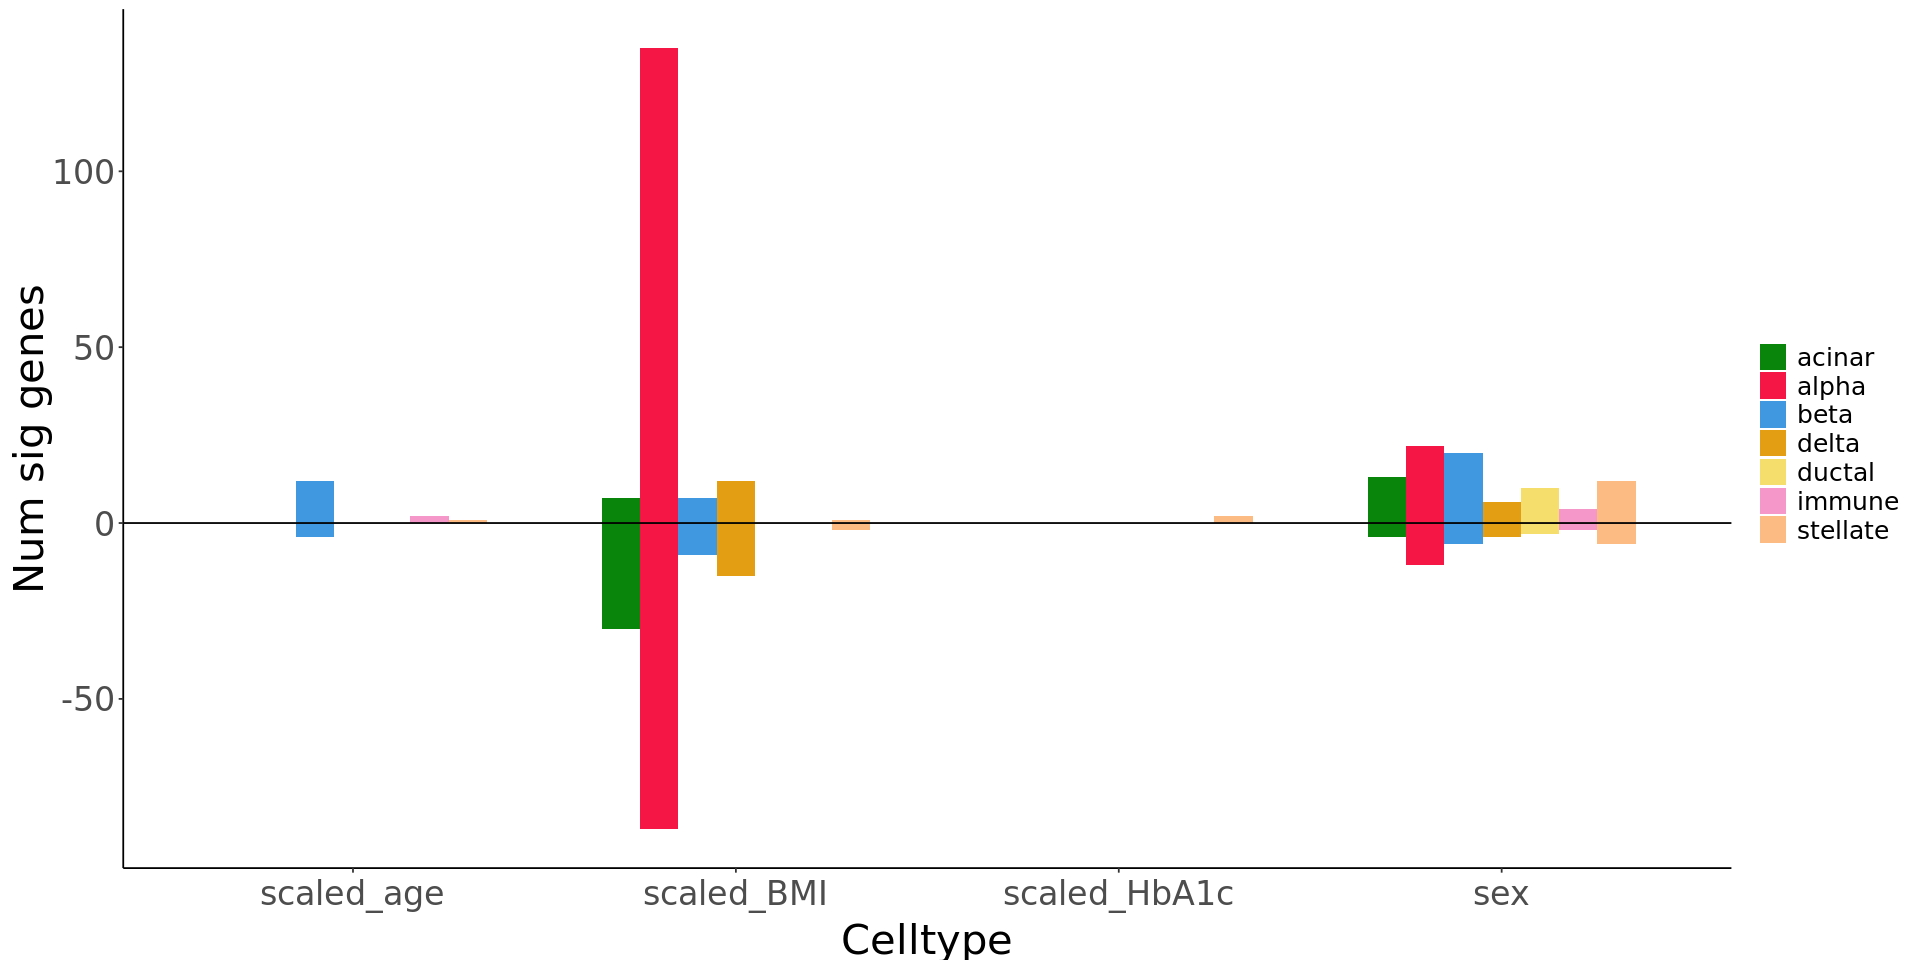

In [11]:
deseq_outdir <- file.path(outdir,'REM_meta')
summarize_REM_DEGs(traits, test_celltypes, deseq_outdir, colors)

# 2. Run pathway enrichment on meta-analysis results

### Read in necessary inputs

In [ ]:
pathway_dir <- '/dir/with/msigdb/pathway/gmt/files'
go <- gmtPathways(file.path(pathway_dir,'c5.go.v2023.1.Hs.symbols.gmt'))
kegg <- gmtPathways(file.path(pathway_dir'c2.cp.kegg.v2023.1.Hs.symbols.gmt'))
reactome <- gmtPathways(file.path(pathway_dir'c2.cp.reactome.v2023.1.Hs.symbols.gmt'))
pathways <- c(go, kegg, reactome)

go_mf <- gmtPathways(file.path(pathway_dir,'c5.go.mf.v2023.1.Hs.symbols.gmt.txt'))
go_bp <- gmtPathways(file.path(pathway_dir,'c5.go.bp.v2023.1.Hs.symbols.gmt.txt'))
pathways2 <- c(kegg,reactome,go_mf,go_bp)

hallmarks <- gmtPathways(file.path(pathway_dir,'h.all.v2023.1.Hs.symbols.gmt.txt'))

In [15]:
#read in ribo and mt genes -- to exclude from analysis
rpl <- fread(file.path(pathway_dir,'group-646.csv'), fill=TRUE, header=TRUE)
rps <- fread(file.path(pathway_dir,'group-728.csv'), fill=TRUE, header=TRUE)
mtr <- fread(file.path(pathway_dir,'group-729.csv'), fill=TRUE, header=TRUE)

ribo_proteins <- c(rpl$V2, rps$V2, mtr$V2)
ribo_proteins <- ribo_proteins[which(ribo_proteins != 'Approved symbol')]

### Run streamlined pathway analysis methods for now

In [23]:
### Function to run fGSEA and write outputs to a file
run_fGSEA_on_REM <- function(celltype, trait, pathways, pathways_name, outdir, only_auto=FALSE){
    #read in REM results and calculate rank?
    fp <- file.path(deseq_outdir, trait, sprintf('%s_%s.all_genes_REM_results.txt', celltype, trait))
    df <- read.table(fp, sep='\t', header=1)
    
    # If only_auto==TRUE, remove any genes on sex chromosomes
    if(only_auto==TRUE){
        ref_df <- read.table('non-diabetic-islet-multiomics/references/gene_coords.gencodev32.hg38.bed', sep='\t', header=FALSE)
        auto_genes <- subset(ref_df, !grepl('X|Y',V1)) %>% pull(V4)
        df_fin <- df[row.names(df) %in% auto_genes,]
    } else{
        df_fin <- df
    }
    
    rank <- -log10(df_fin$pvalue) * df_fin$effect
    names(rank) <- rownames(df_fin)

    #Run fGSEA
    res <- fgsea(pathways = pathways, 
                 stats    = rank,
                 eps      = 0.0,
                 minSize  = 0,
                 maxSize  = 500)

    # Output results to a file (sorted by padj)
    out_fp <- file.path(outdir, sprintf('%s_%s.all_genes_REM_results_fGSEA_%s.txt', celltype, trait, pathways_name))
    fwrite(res[order(res$padj),], file=out_fp, sep="\t", sep2=c("", " ", ""))
}

In [24]:
fgsea_outdir <- file.path(outdir, 'REM_fGSEA')
for(trait in traits){
    trait_outdir <- file.path(fgsea_outdir, trait)
    dir.create(trait_outdir, showWarnings=FALSE)
    for(celltype in test_celltypes){
        run_fGSEA_on_REM(celltype, trait, pathways2, 'GO_KEGG_Reactome', trait_outdir, FALSE)
        run_fGSEA_on_REM(celltype, trait, hallmarks, 'Hallmark', trait_outdir, FALSE)
    }
}

# 2b. Make summary plots of fGSEA results

In [34]:
### summarize sig genes results (plot with up and down as + and -)
summarize_REM_pathways <- function(traits, celltypes, pathways_name, fgsea_outdir, colors, padj_cutoff=0.1){
    #collect up and down info separately
    summary_df_up <- data.frame()
    for (celltype in celltypes){
        num_sig <- c()
        for (trait in traits){
            fp <- file.path(fgsea_outdir1, trait, sprintf('%s_%s.all_genes_REM_results_fGSEA_%s.txt', celltype, trait, pathways_name))
            df <- read.table(fp, sep='\t', header=TRUE)
            num_sig <- c(num_sig, dim(df[df$padj < padj_cutoff & df$ES > 0,])[1])
        }
        summary_df_up <- rbind(summary_df_up, num_sig)
    }
    colnames(summary_df_up) <- traits

    summary_df_down <- data.frame()
    for (celltype in celltypes){
        num_sig <- c()
        for (trait in traits){
            fp <- file.path(fgsea_outdir1, trait, sprintf('%s_%s.all_genes_REM_results_fGSEA_%s.txt', celltype, trait, pathways_name))
            df <- read.table(fp, sep='\t', header=TRUE)
            num_sig <- c(num_sig, dim(df[df$padj < padj_cutoff & df$ES < 0,])[1])
        }
        summary_df_down <- rbind(summary_df_down, num_sig)
    }
    colnames(summary_df_down) <- traits

    #merge up/down dfs into one dataframe
    summary_df_up$celltype <- celltypes
    summary_df_down <- -summary_df_down
    summary_df_down$celltype <- celltypes
    data <- rbind(melt(summary_df_up, id.vars='celltype'), melt(summary_df_down, id.vars='celltype'))

    # Make grouped barplot of desired metadata
    options(repr.plot.width=16, repr.plot.height=8)
    theme_set(
        theme_classic())

    p1 <- ggplot(data, aes(fill=celltype, y=value, x=variable)) + 
            geom_bar(position="dodge", stat="identity", width=0.7) + 
            geom_hline(yintercept=0) + 
            labs(x = "Celltype", y='Num sig pathways', color="Cell Type", title=pathways_name) + 
            scale_fill_manual(values=colors) + 
            theme(axis.text.x=element_text(size=20, vjust=0.5),
            axis.text.y=element_text(size=20, vjust=0.5),
            axis.title.x = element_text(size=25, vjust=-0.35),
            axis.title.y = element_text(size=25, vjust=0.5),
            legend.title = element_blank(),
            legend.text = element_text(size=15),
            plot.title = element_text(size=25, hjust=0.5, face="bold"))
    print(p1)
}

Warning message in melt(summary_df_up, id.vars = "celltype"):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(summary_df_up). In the next version, this warning will become an error.”
Warning message in melt(summary_df_down, id.vars = "celltype"):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(summary_df_down). In the next version, this warning will become an error.”
Warning me

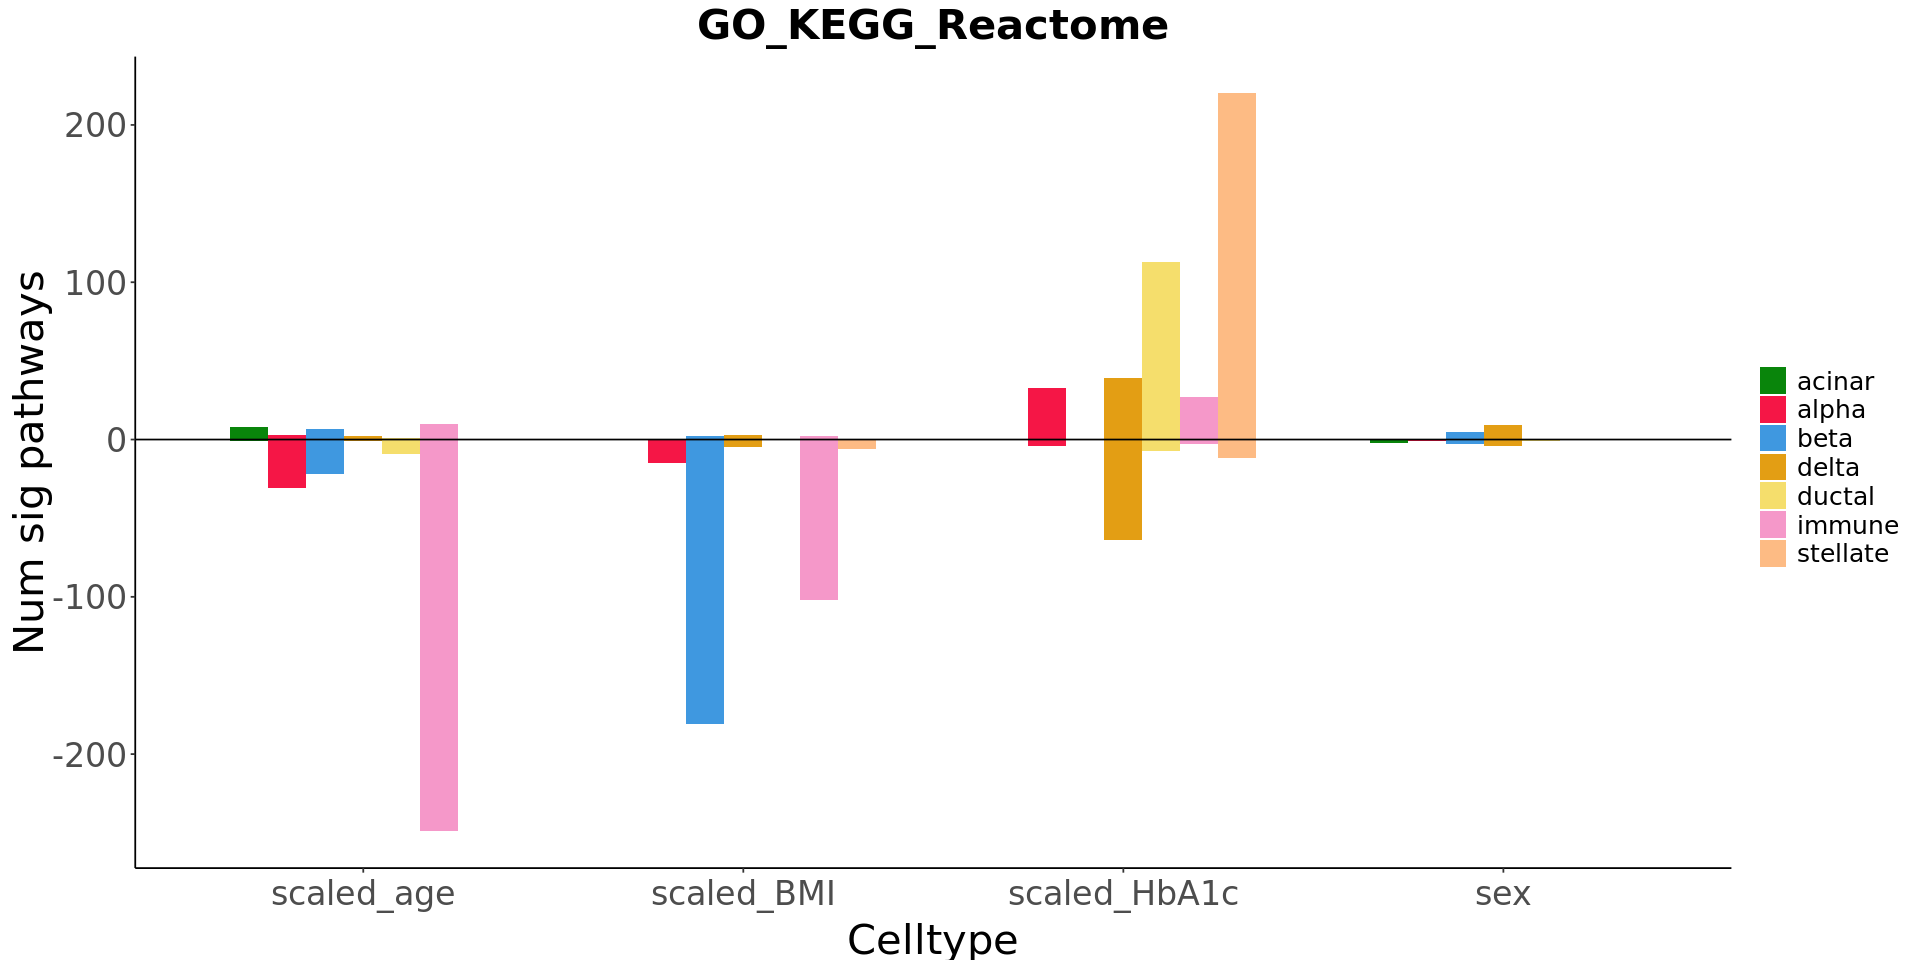

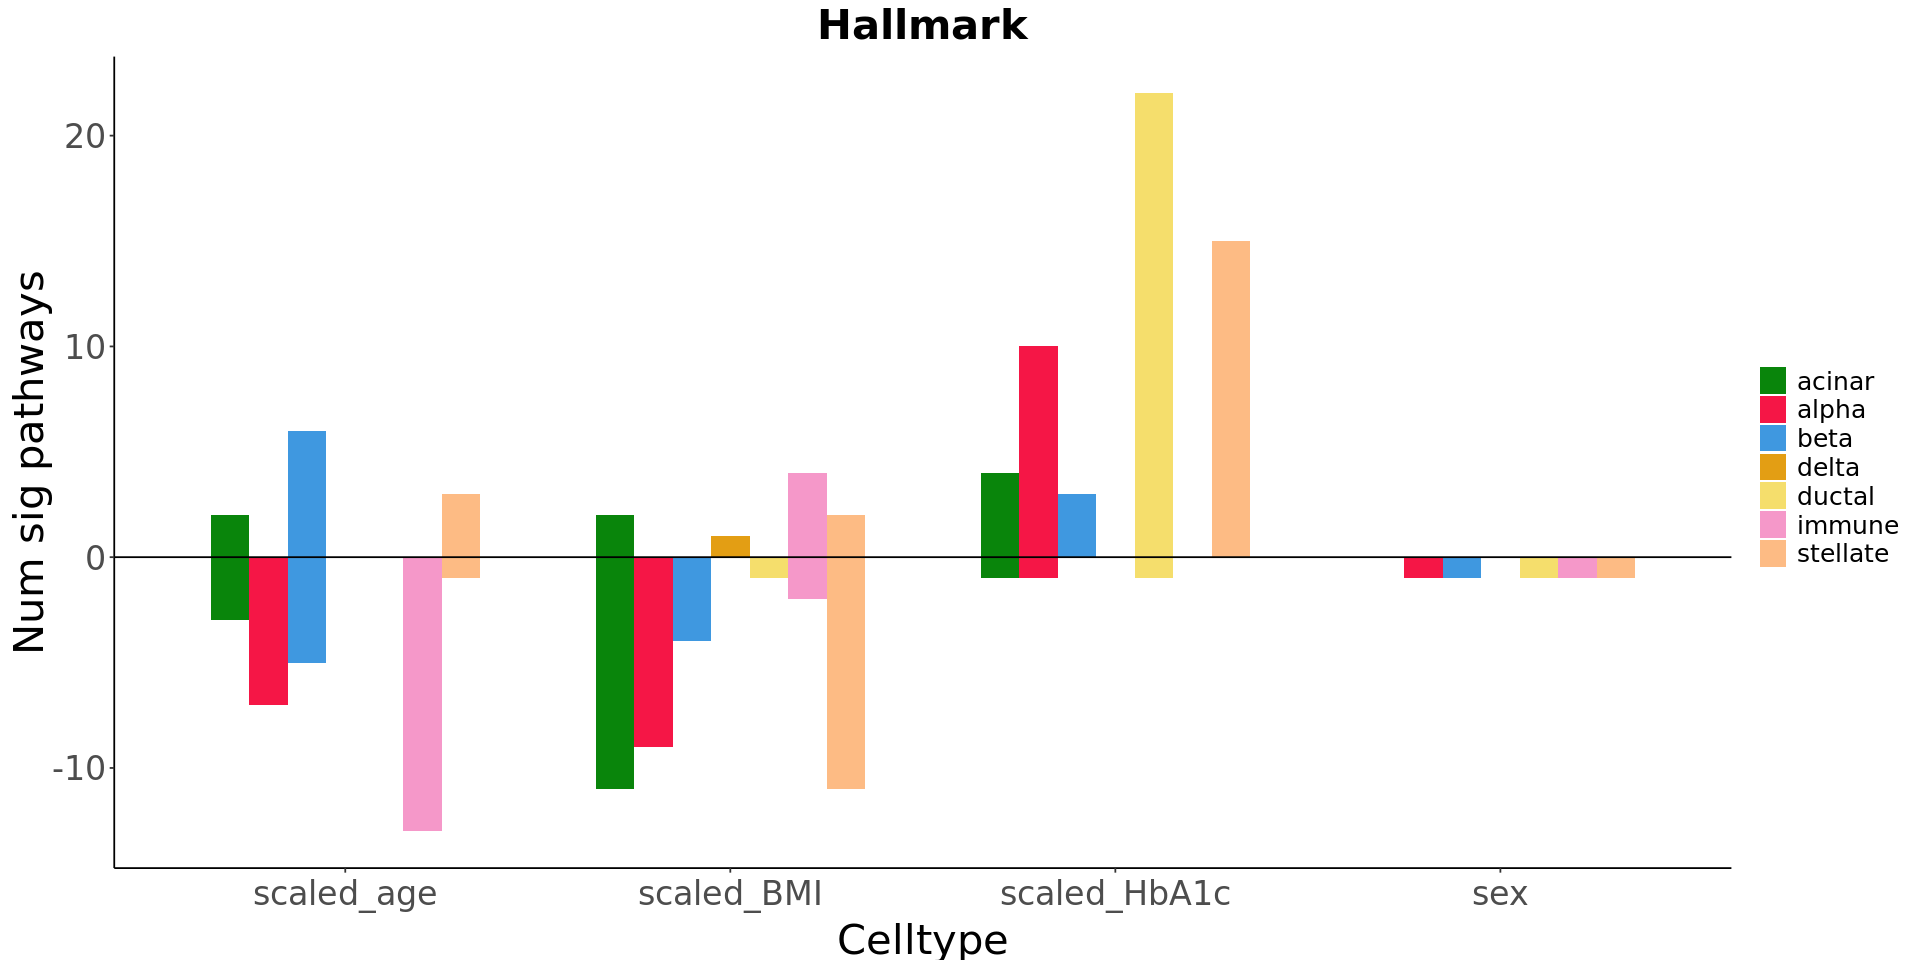

In [35]:
summarize_REM_pathways(traits, test_celltypes, 'GO_KEGG_Reactome', fgsea_outdir, colors, padj_cutoff=0.1)
summarize_REM_pathways(traits, test_celltypes, 'Hallmark', fgsea_outdir, colors, padj_cutoff=0.1)

In [30]:
#adapting previous plotting function to just make one plot at a time so I can make a composite plot more easily
gsea_one_dir_plt <- function(data, cell, var, color, numpathways, labelthresh, plt_dir){
    plt_title <- sprintf('%s %s-regulated pathways (-log10p)', var, plt_dir)

    #prepare df for plotting
    data$LOG10P <- -log10(data$pval)
    data <- data[order(data$pval),]

    #cut df down to just up/down pathways
    if (plt_dir == 'up'){
        plt_data <- data[which(data$ES > 0),][c(1:numpathways),]        
    } else if (plt_dir == 'down'){
        plt_data <- data[which(data$ES < 0),][c(1:numpathways),]            
    }
    
    #before preceding, make sure there are still things to plot
    #check if still have any pathways after selecting up/down
    plt_data <- na.omit(plt_data)
    make_plot <- ifelse(dim(plt_data)[1] > 0, TRUE, FALSE)
    
    if (make_plot == TRUE){        
        #factor pathways (idk why)
        plt_data$pathway <- factor(plt_data$pathway, levels= plt_data$pathway)
        plt_data$pathway <- fct_rev(plt_data$pathway)

        #make plot 
        plt <- ggplot(plt_data) +
                      geom_col(aes(LOG10P, pathway), fill= color, width = 0.9) + theme_classic() + 
                      scale_x_continuous(limits = c(0, (ceiling(max(plt_data$LOG10P, na.rm = TRUE)) + 0.5)),
                        breaks = seq(0, ceiling(max(plt_data$LOG10P, na.rm = TRUE)), by = 3), 
                        expand = c(0, 0), # The horizontal axis does not extend to either side
                        position = 'top') + # Labels are located on the top
                      scale_y_discrete(expand = expansion(add = c(0, 0.5))) +
                      theme(panel.background = element_rect(fill = 'white'),
                        panel.grid.major.x = element_line(color = '#A8BAC4', size = 0.1), #change to 0.3 possibly?
                        axis.ticks.length = unit(0, 'mm'),
                        axis.title = element_blank(),
                        axis.line.y.left = element_line(color = 'black'),
                        axis.text.y = element_blank(),
                        axis.text.x = element_text(size = 16)) + 
                      geom_shadowtext(
                        data = subset(plt_data, LOG10P >= labelthresh),
                        aes(0, y = pathway, label = pathway),
                        hjust = 0,
                        nudge_x = 0.3,
                        colour = 'white',
                        bg.colour = color,
                        bg.r = 0.2,
                        size = 10) + 
                      geom_text(data = subset(plt_data, LOG10P >= labelthresh),
                        aes(0, y = pathway, label = pathway),
                        hjust = 0,nudge_x = 0.3,colour = 'white',size = 10) +
                      labs(title = '', subtitle = plt_title) +
                      theme(plot.title = element_text(face = 'bold',size = 15),
                        plot.subtitle = element_text(size = 20))  
        
    #if no data passes sig threshold return blank plot
    } else {
        plt <- ggplot(plt_data) + 
                    geom_blank() + 
                    labs(title = '', subtitle = plt_title) +
                    theme(panel.background = element_rect(fill = 'white'),
                        panel.grid.major.x = element_line(color = '#A8BAC4', size = 0.1), #change to 0.3 possibly?
                        axis.ticks.length = unit(0, 'mm'),
                        axis.title = element_blank(),
                        axis.line.y.left = element_line(color = 'black'),
                        axis.text.y = element_blank(),
                        axis.text.x = element_text(size = 16),
                        plot.title = element_text(face = 'bold',size = 15),
                        plot.subtitle = element_text(size = 20))
    }
    return(plt)
}

In [31]:
### Short wrapper function for Ruth's plots, reads in res from a fp and then filters for padj threshold
### 7/12/23: adapted to make all plots for each trait for a cell type using new function and ggarrange them
make_ct_pathway_plots <- function(celltype, traits, fgsea_outdir, pathways_name, threshold, colors){
    plot_list <- list()
    
    for (trait in traits){
        # Read in df and filter for significant results
        fp <- file.path(fgsea_outdir, trait, sprintf('%s_%s.all_genes_REM_results_fGSEA_%s.txt', celltype, trait, pathways_name))
        df <- read.table(fp, sep='\t', header=TRUE)
        df_sig <- na.omit(df[df$padj < threshold,])

        # Make two cell type colors
        color_up <- colors[[celltype]]
        color_down <- colorRampPalette(colors = c('black',color_up))(4)[3]
        
        #Adjust pathway names (lower case and remove hallmark if applicable)
        df_sig$pathway <- tolower(df_sig$pathway)
        if (pathways_name == 'Hallmark'){
            df_sig$pathway <- gsub('hallmark_','',df_sig$pathway)
        }

        # Call newly adapted version Ruth's function to make up and down plots separately
        plt_down <- gsea_one_dir_plt(df_sig, celltype, trait, color_down, 10, 1, 'down')
        plt_up <- gsea_one_dir_plt(df_sig, celltype, trait, color_up, 10, 1, 'up')
        plot_list[[paste(trait,'down',sep='-')]] <- plt_down
        plot_list[[paste(trait,'up',sep='-')]] <- plt_up
    }
    #make composite plot
    options(repr.plot.width = 30, repr.plot.height=10)
    fig <- ggarrange(plotlist = plot_list, nrow=2, ncol=4)
    fig <- annotate_figure(fig, top=text_grob(sprintf("fGSEA %s pathways for %s cells (DESeq phenotype associations)", pathways_name, celltype),
                           color = 'black', face='bold', size=25))
    print(fig)
}

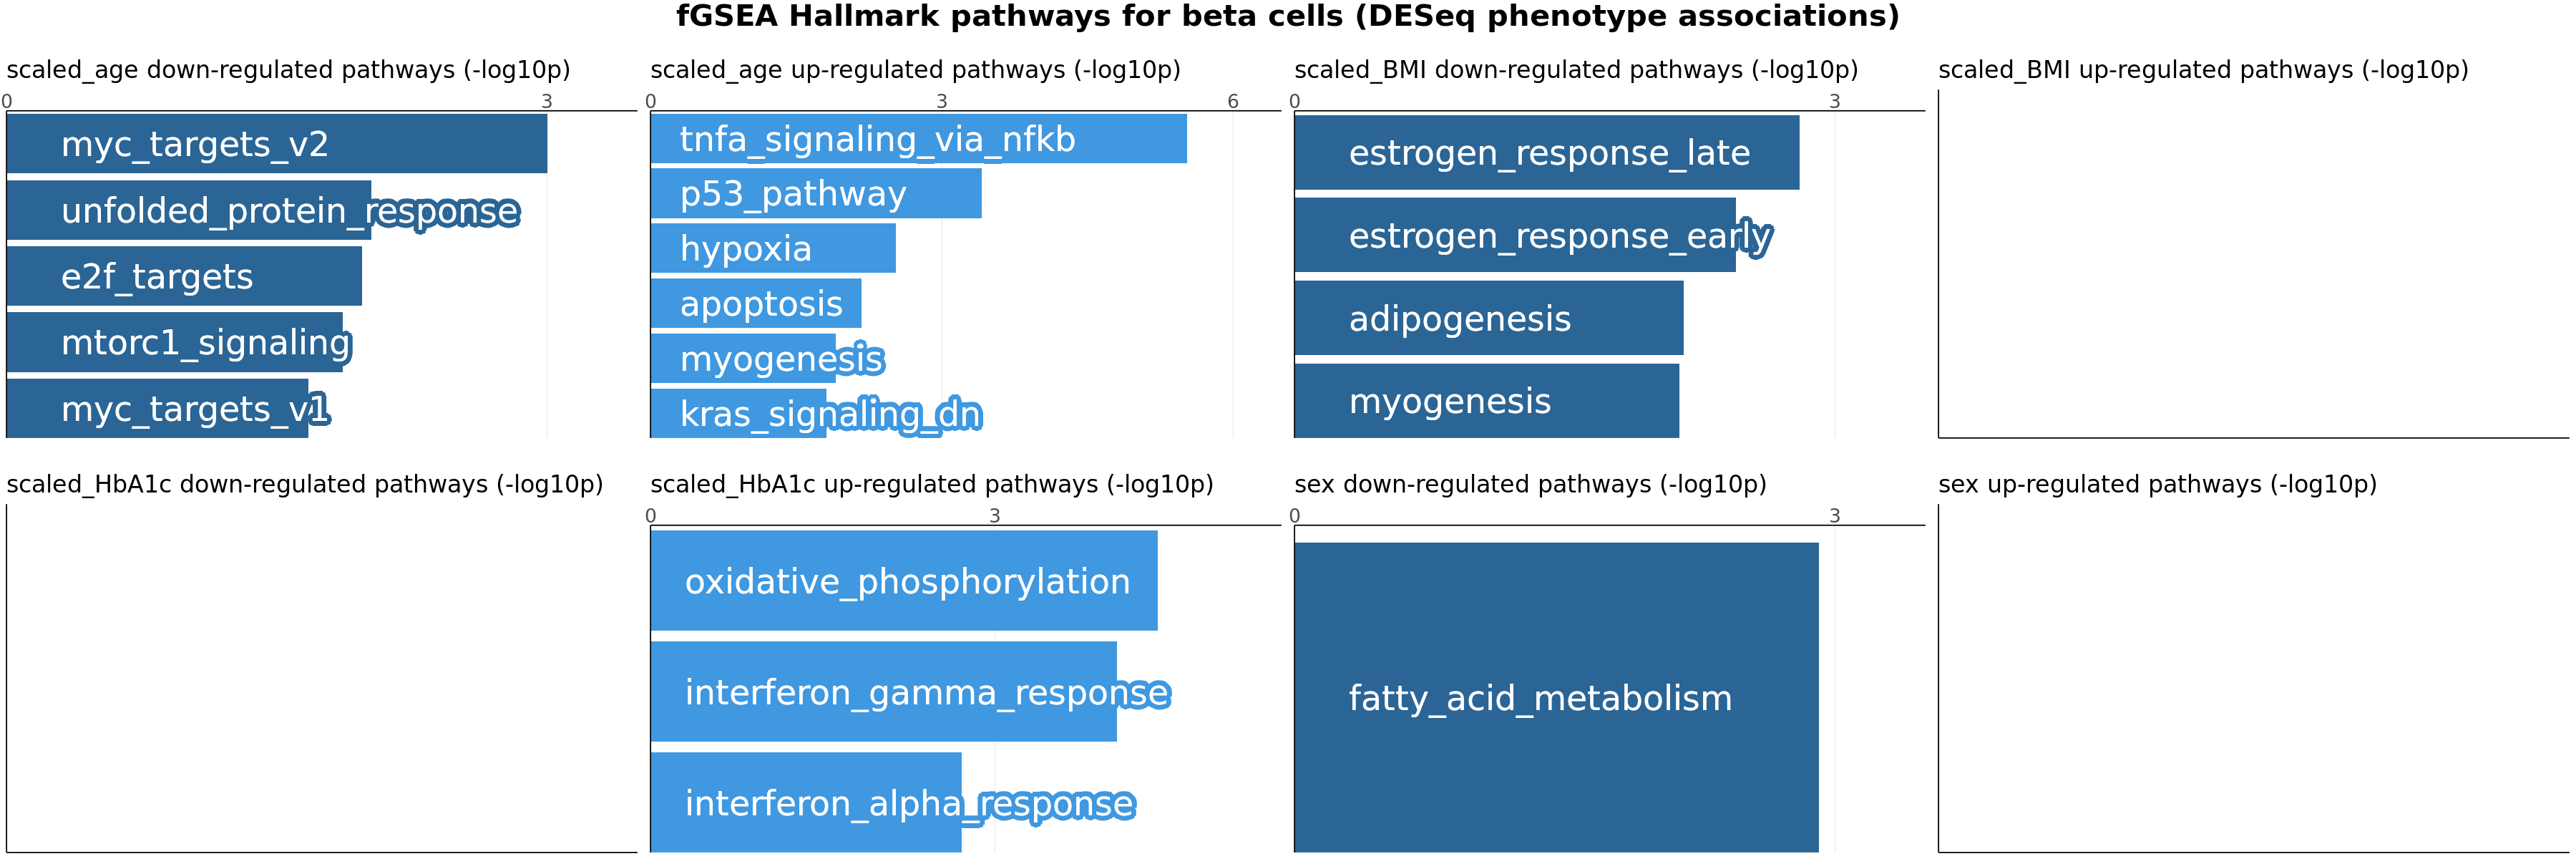

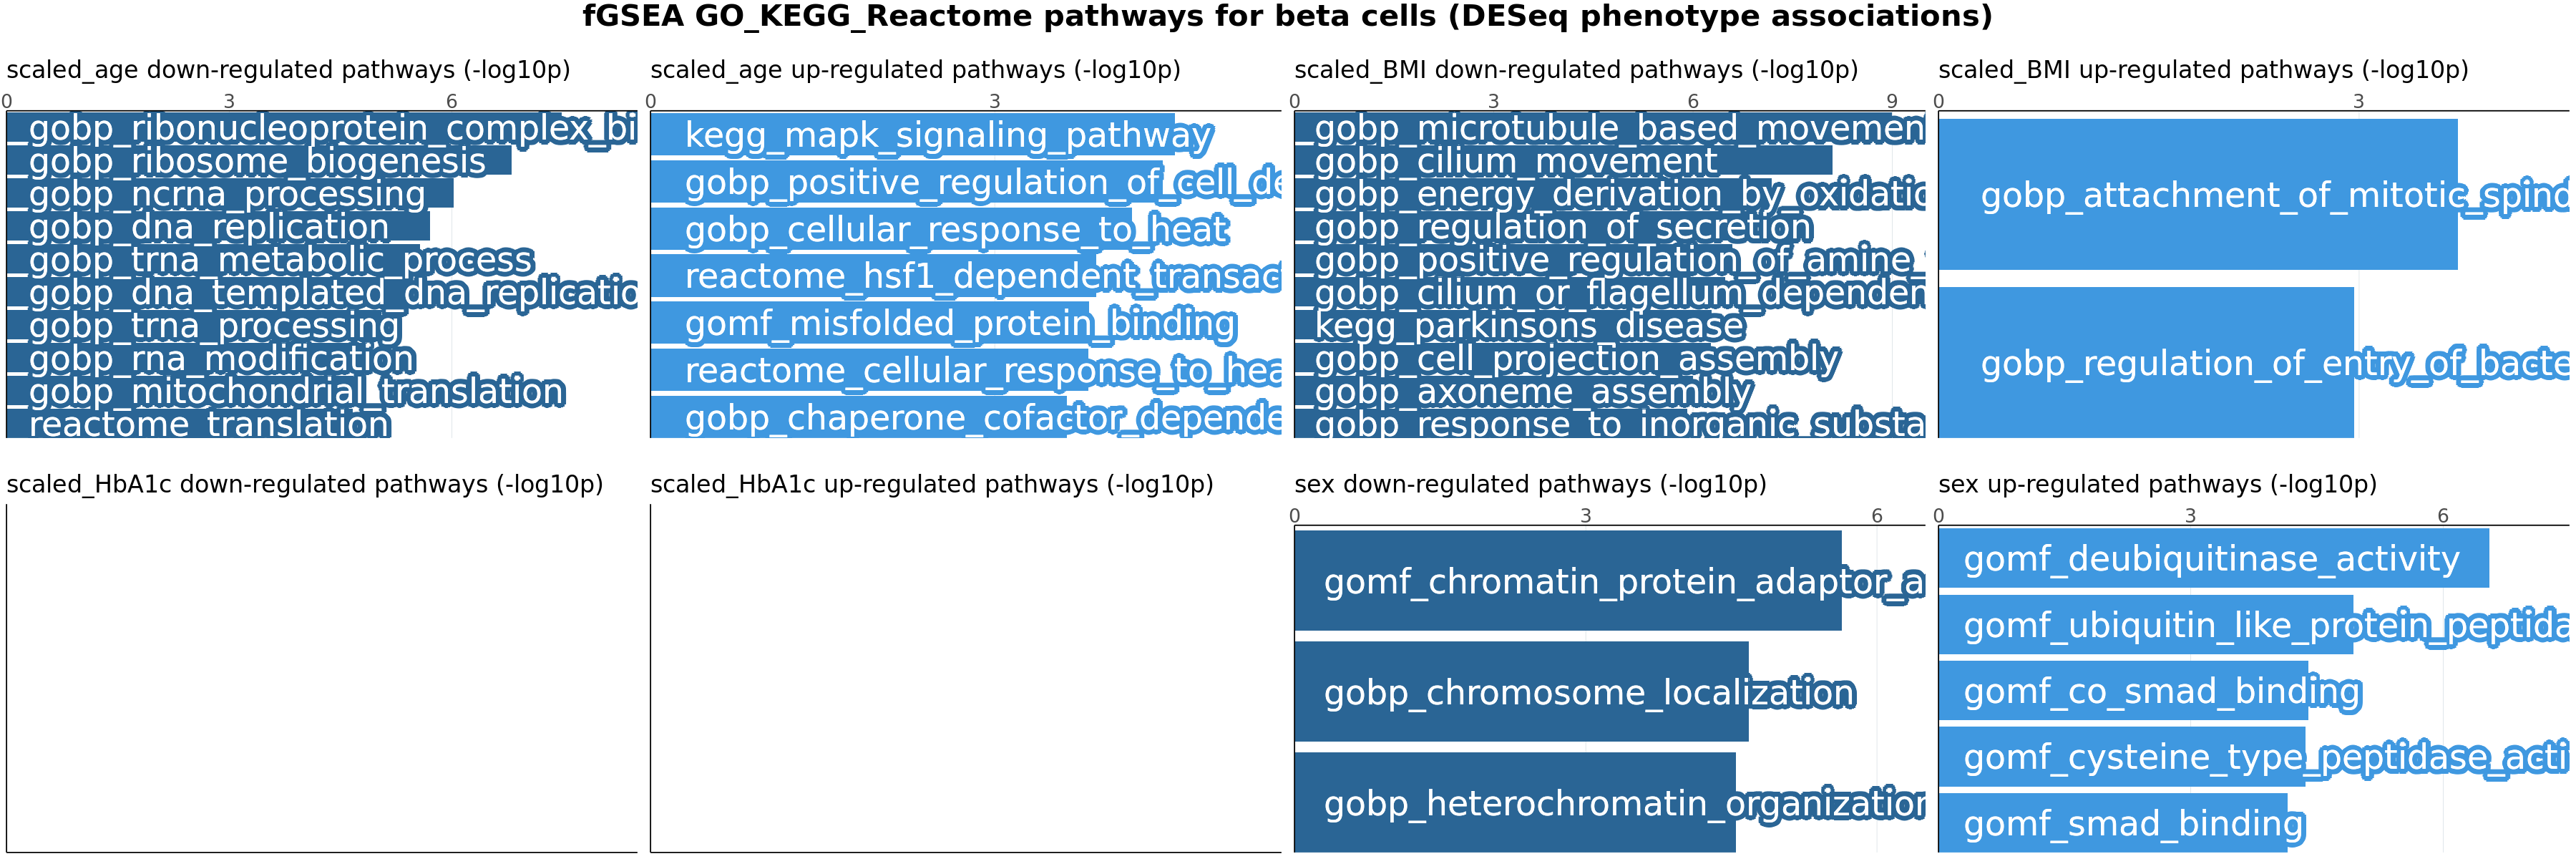

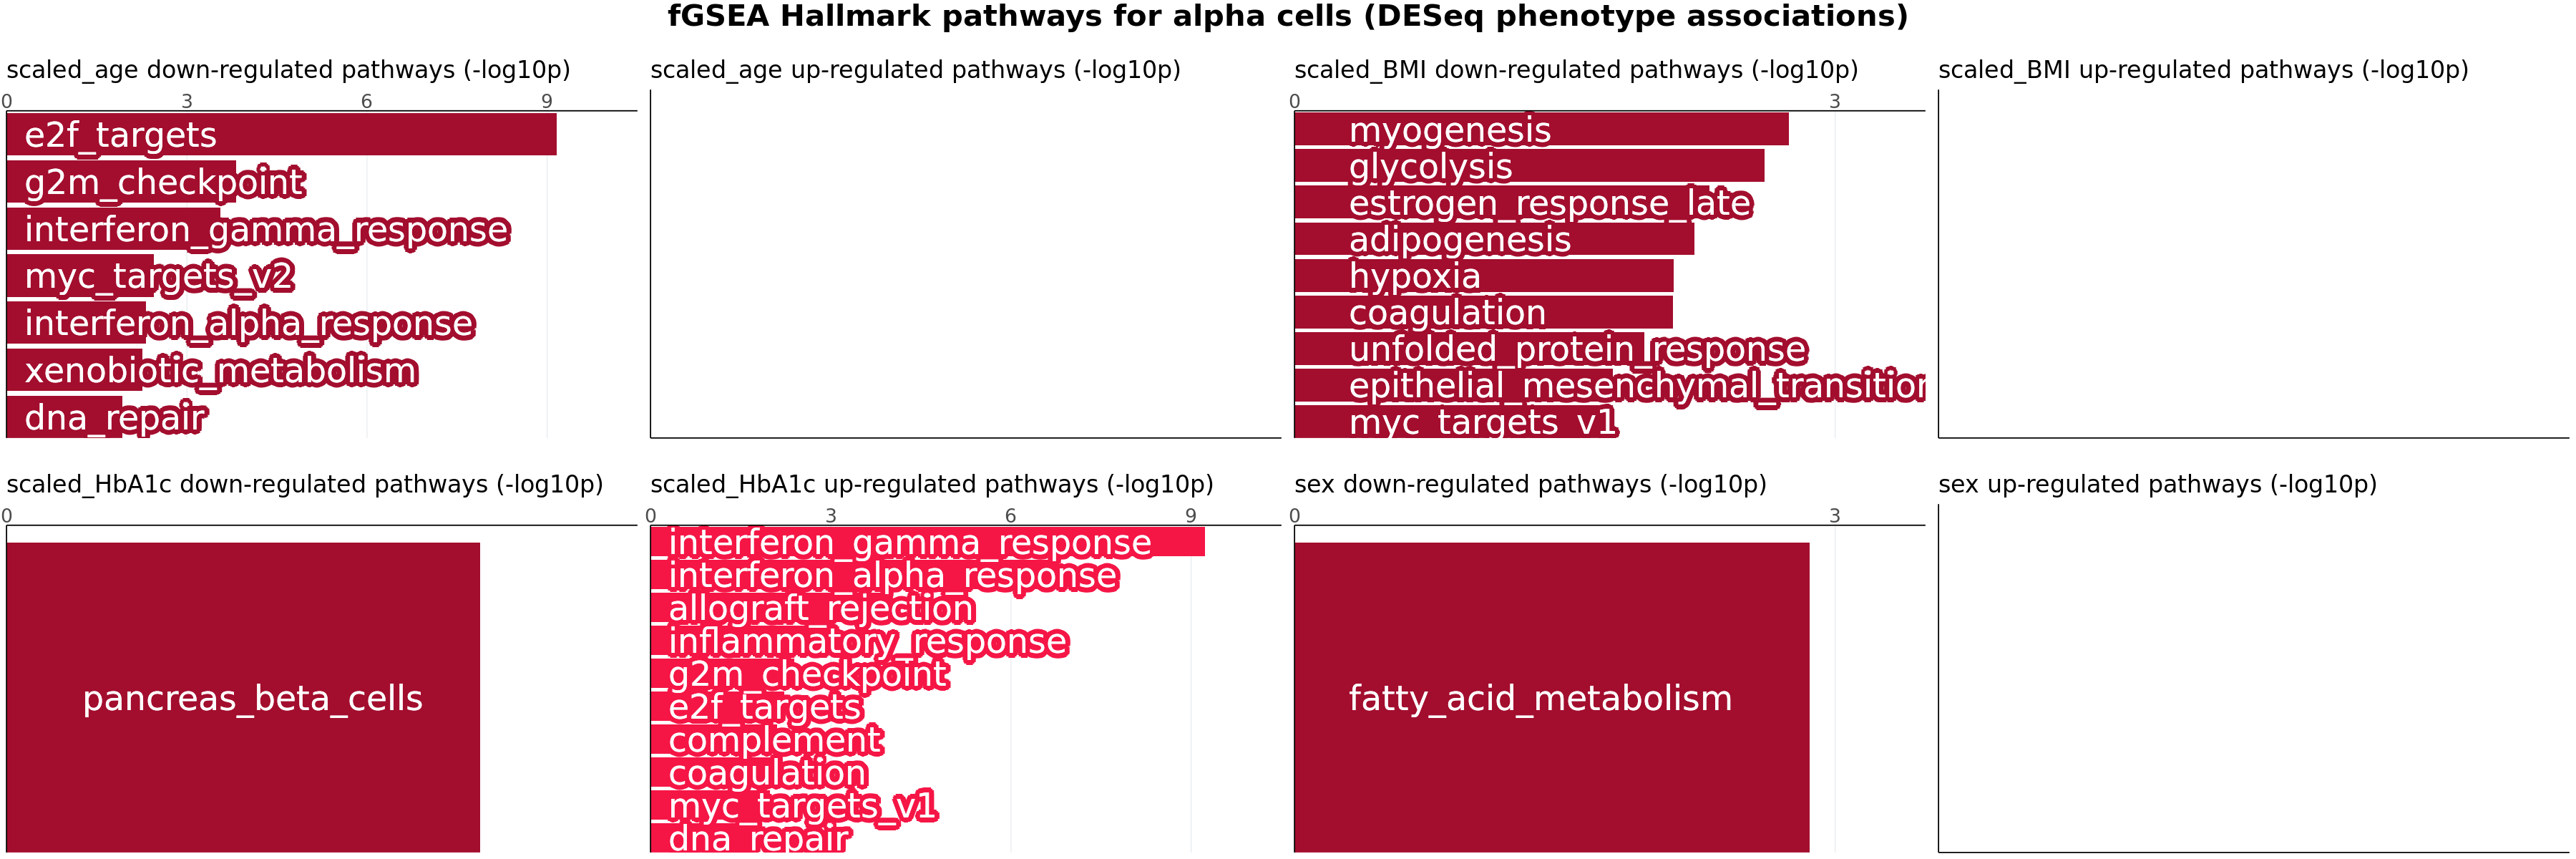

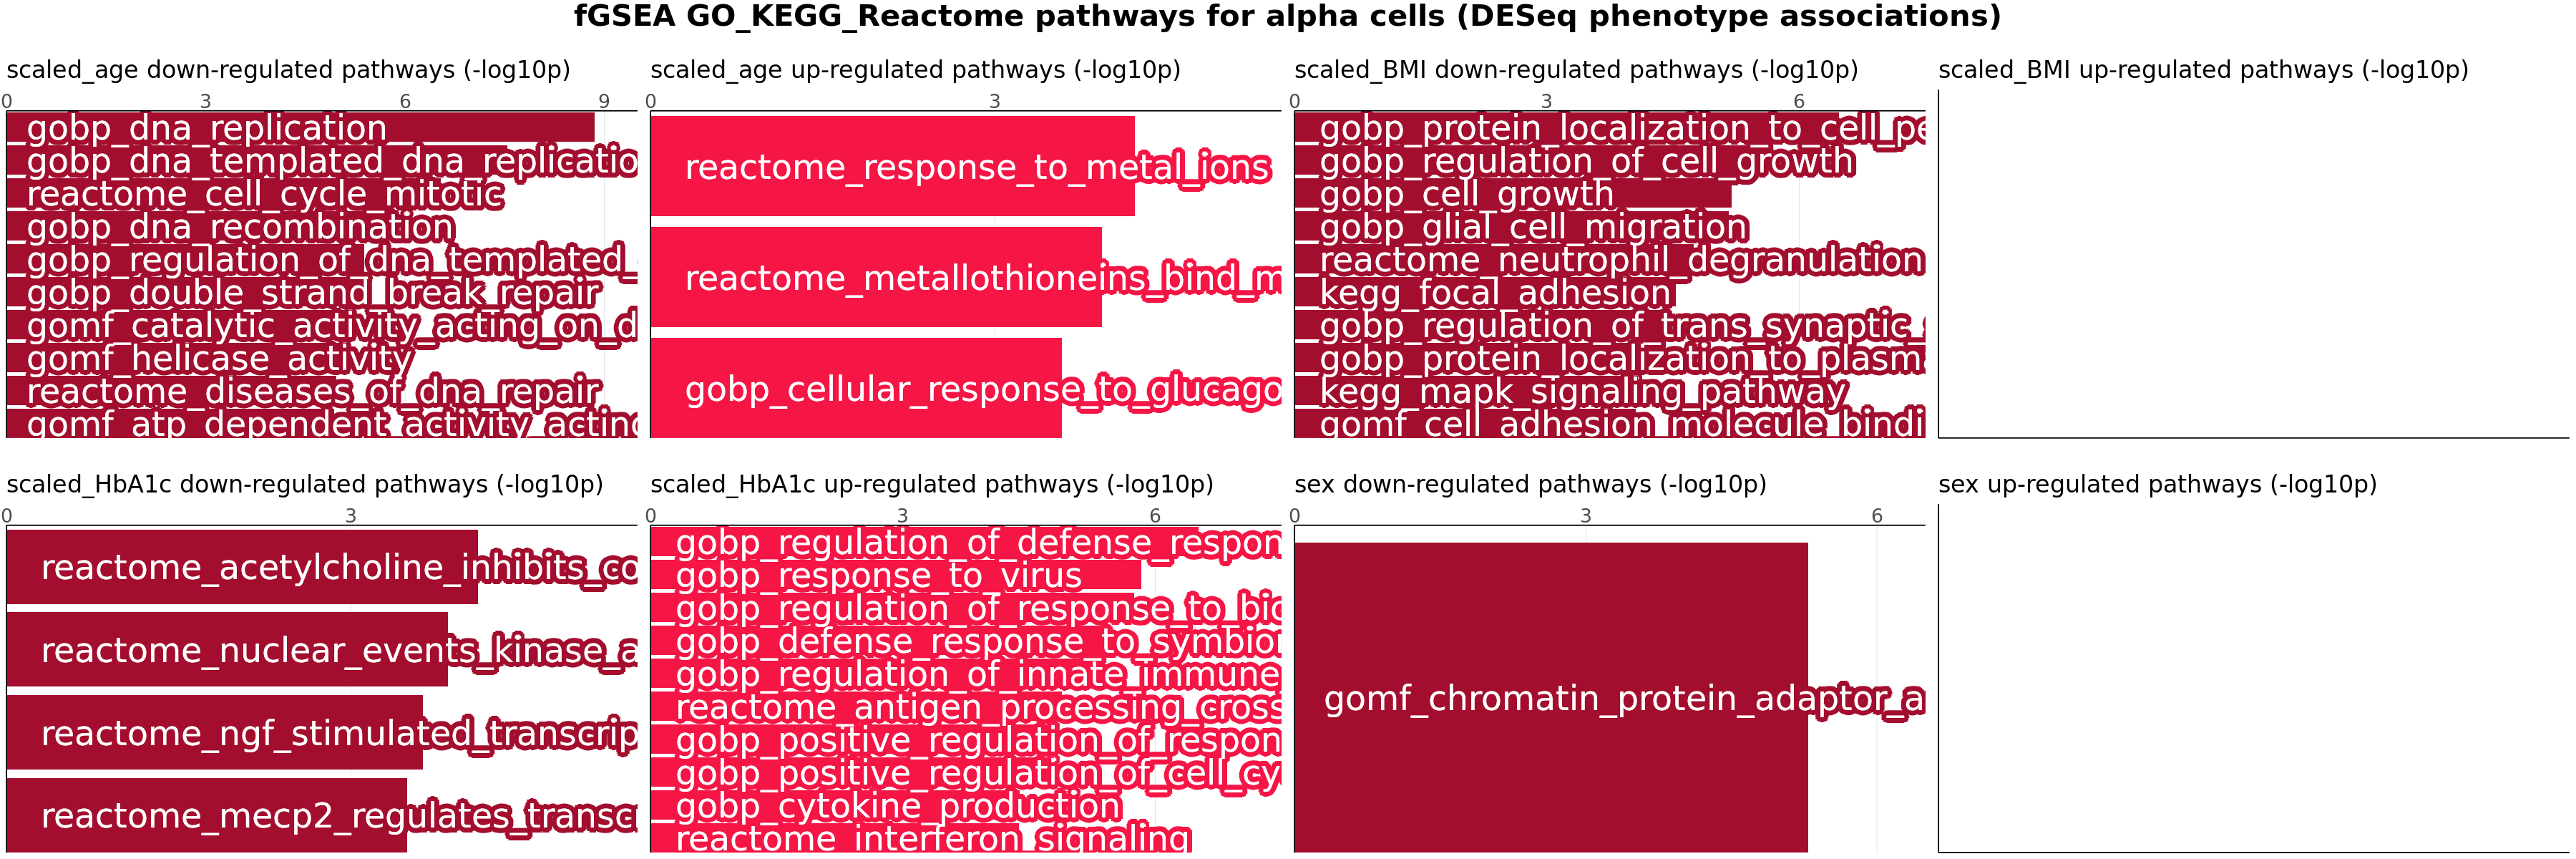

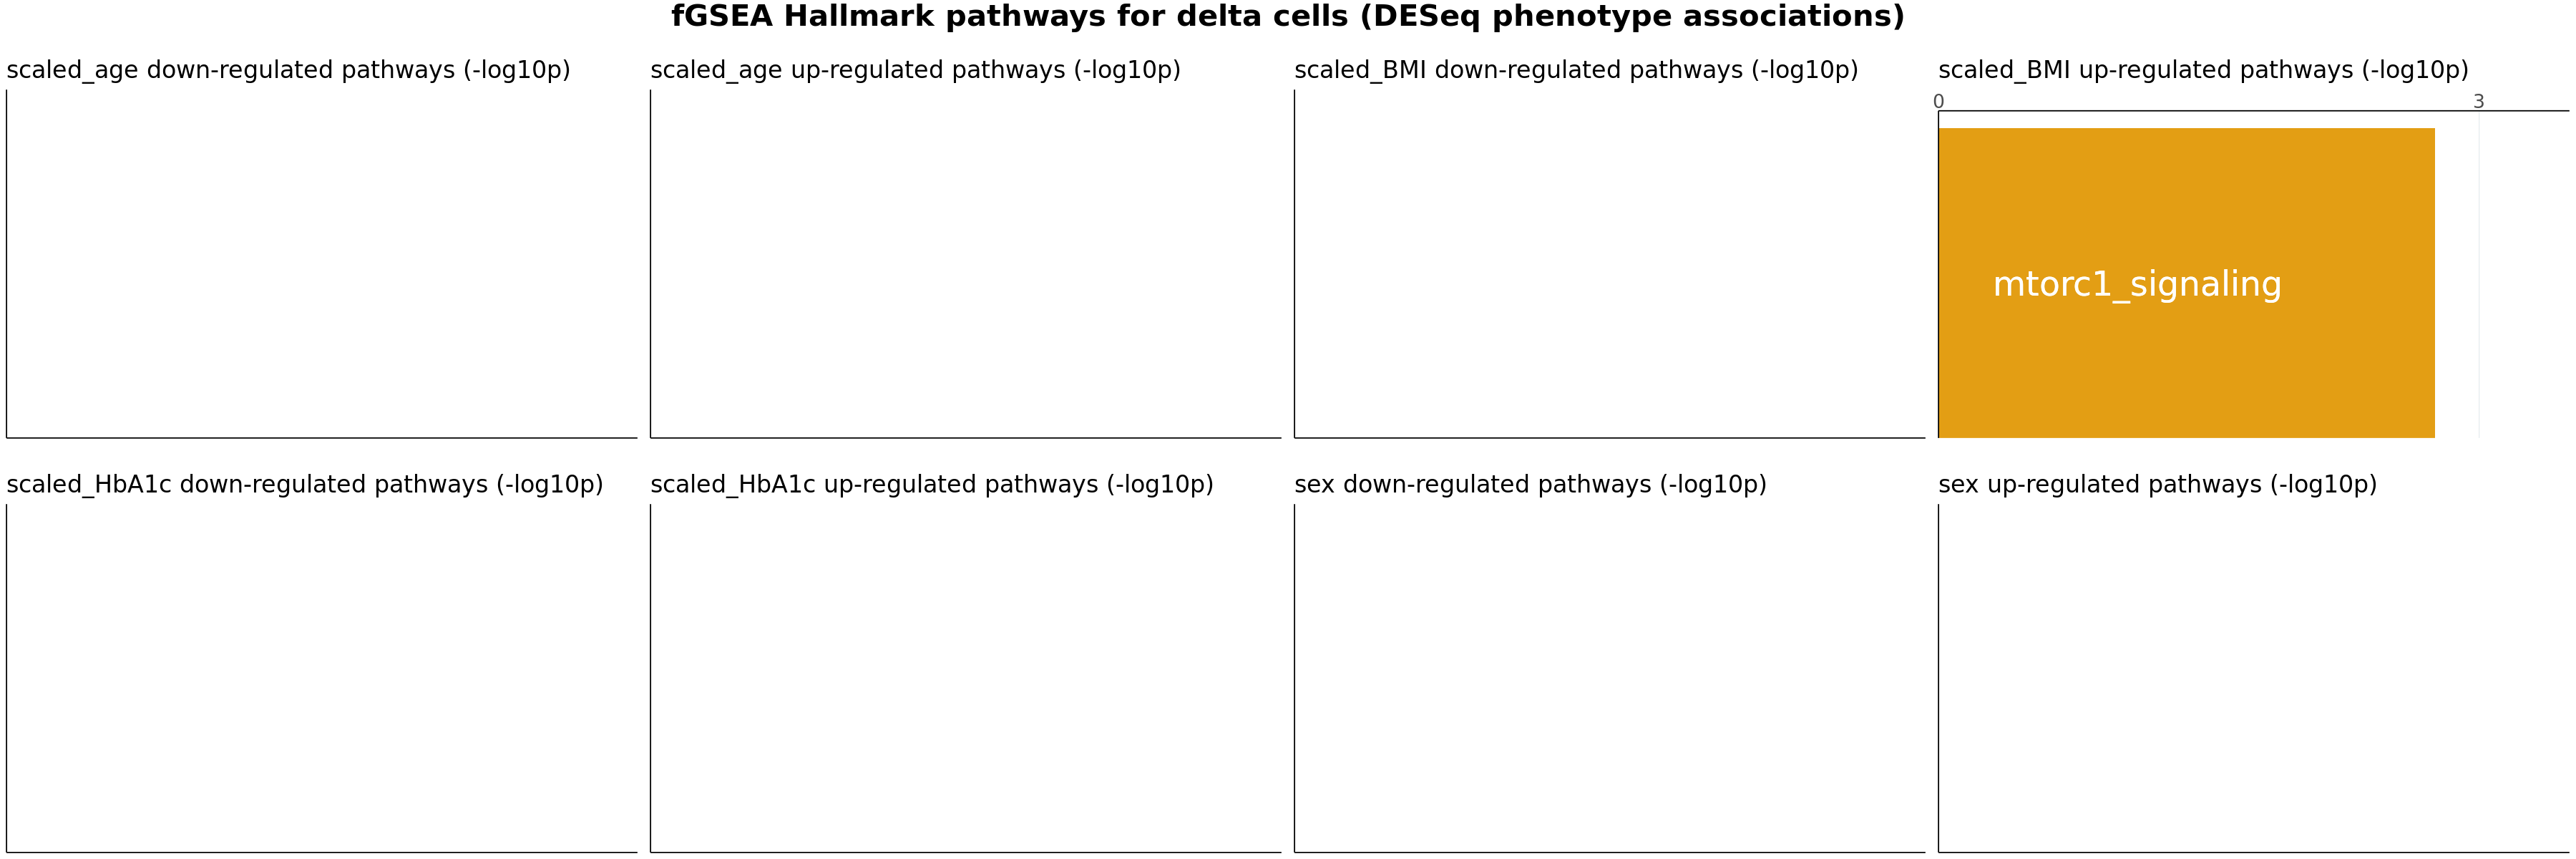

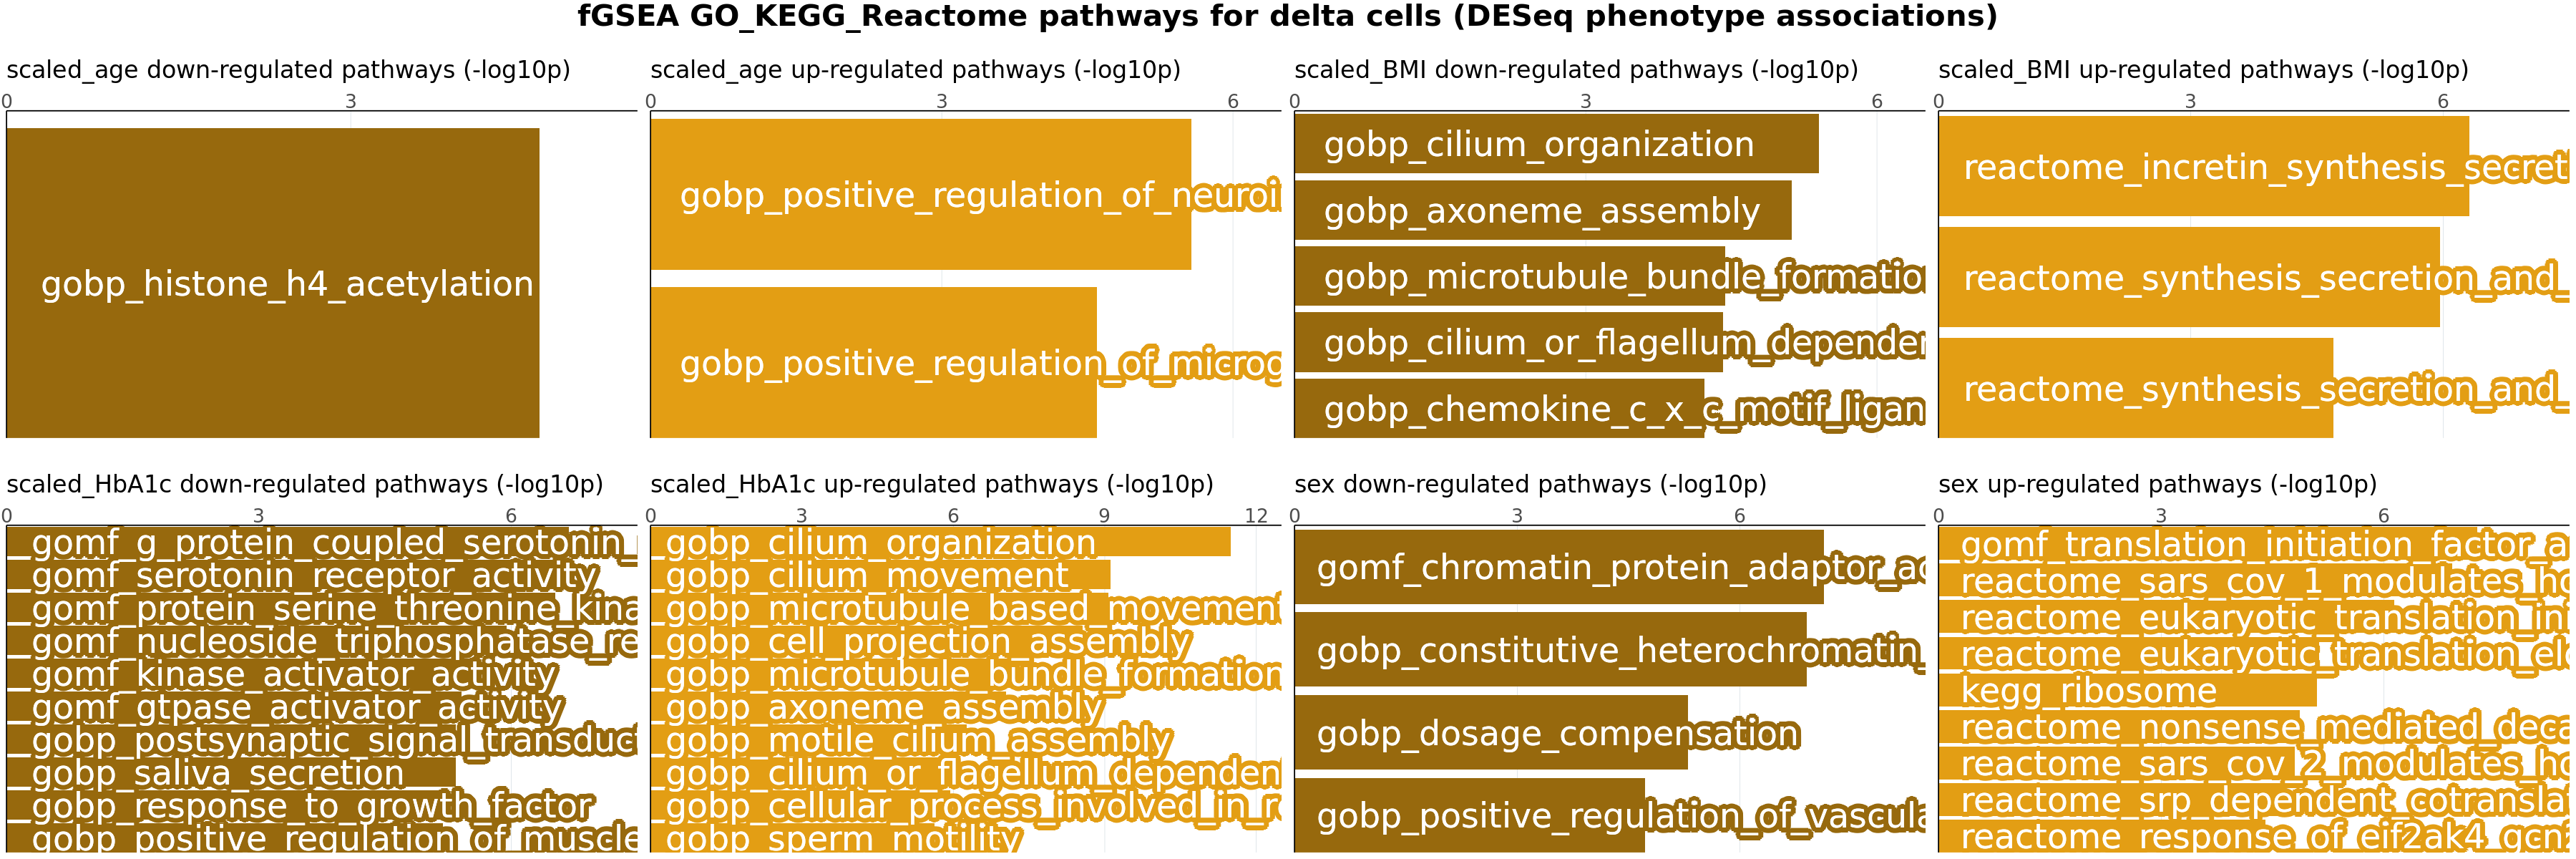

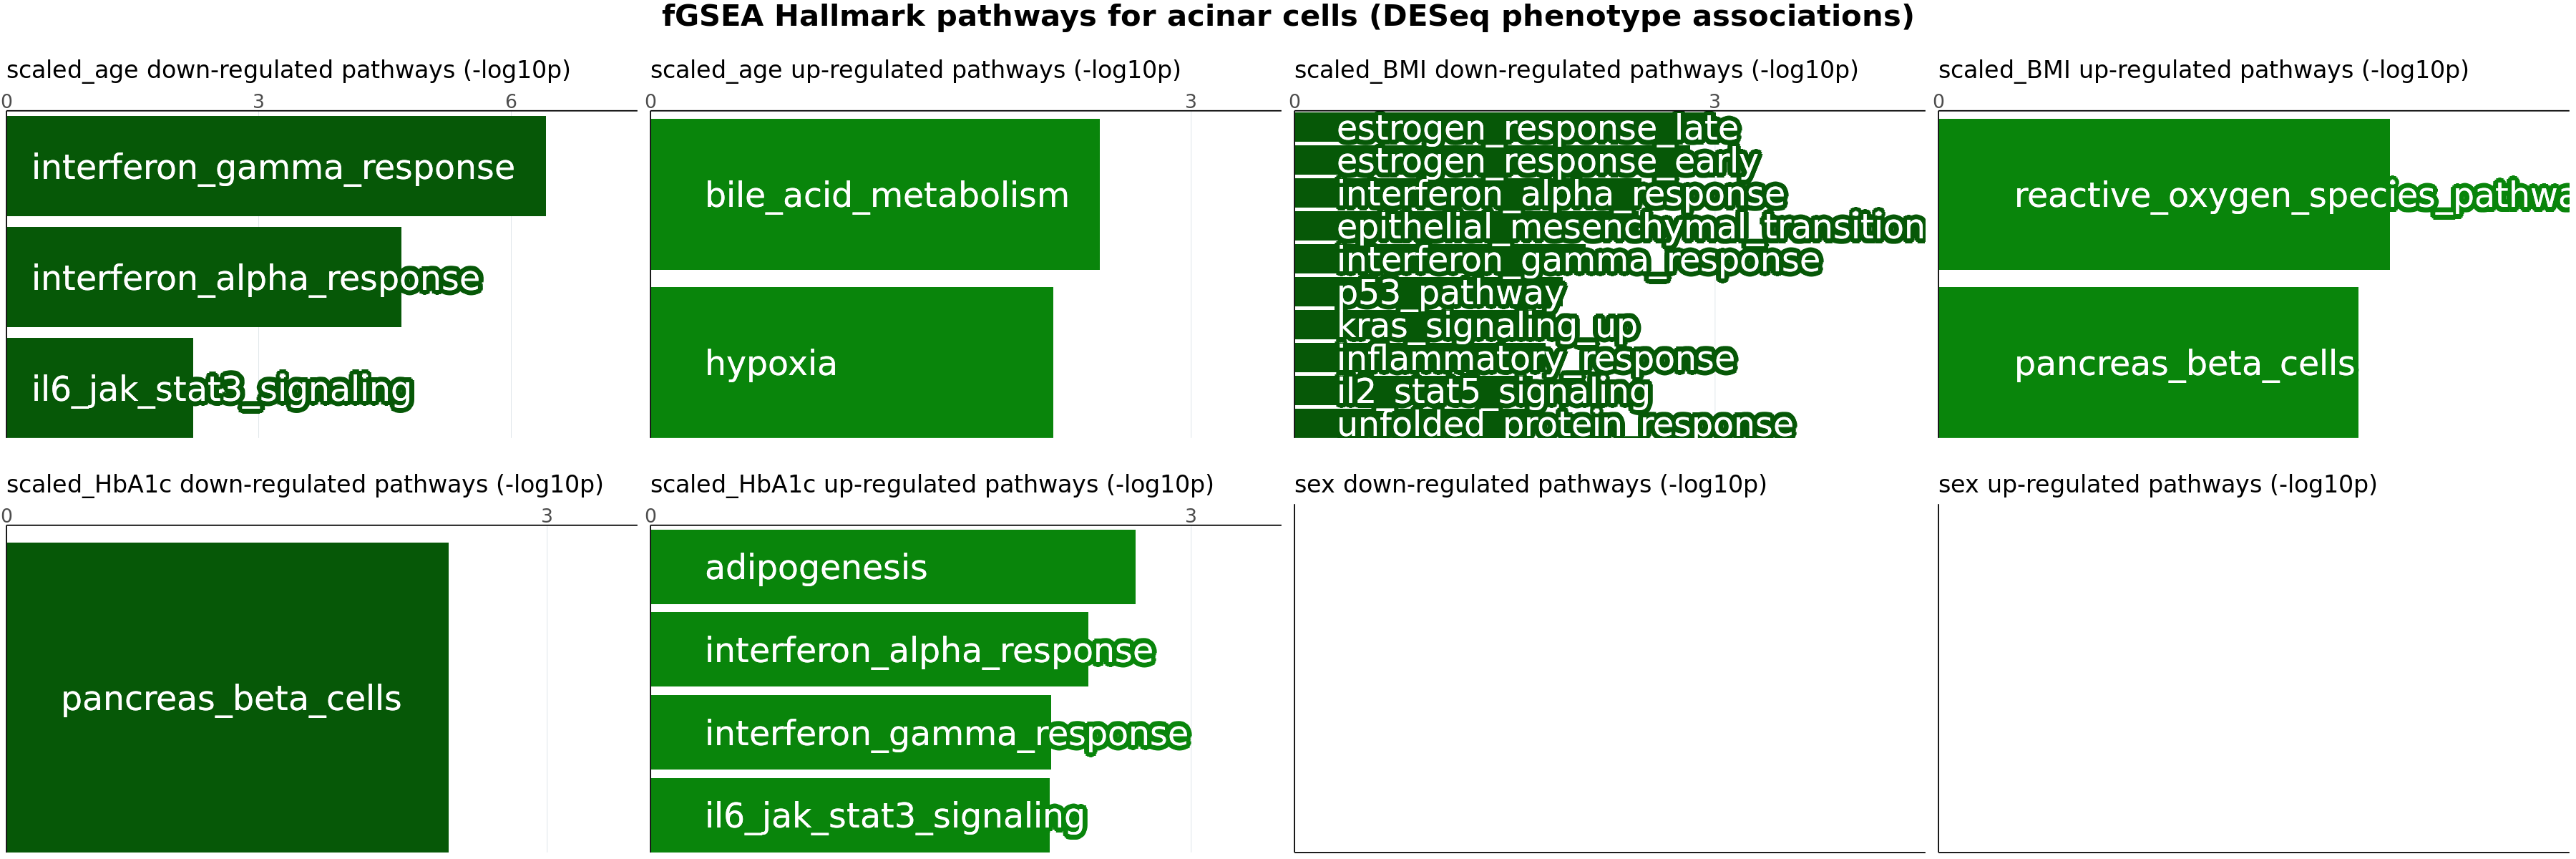

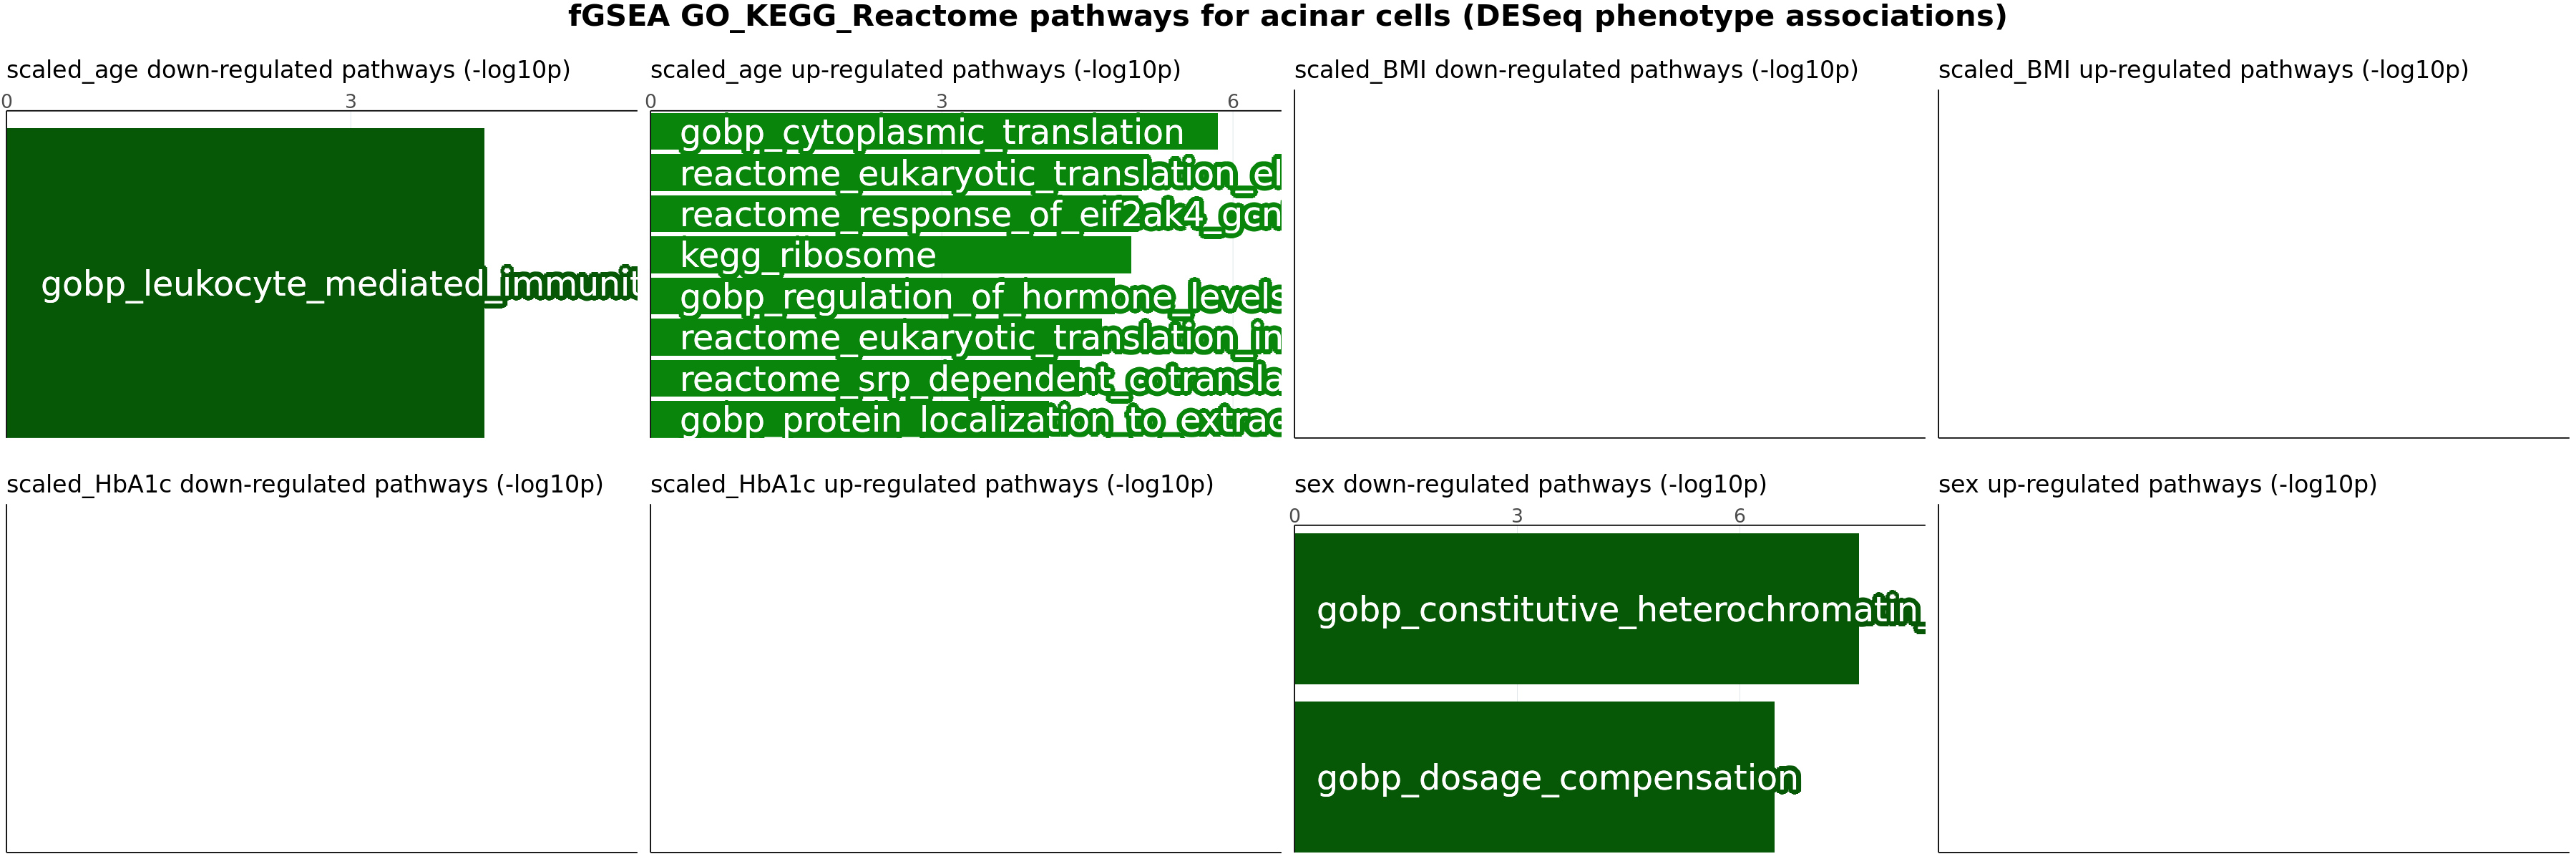

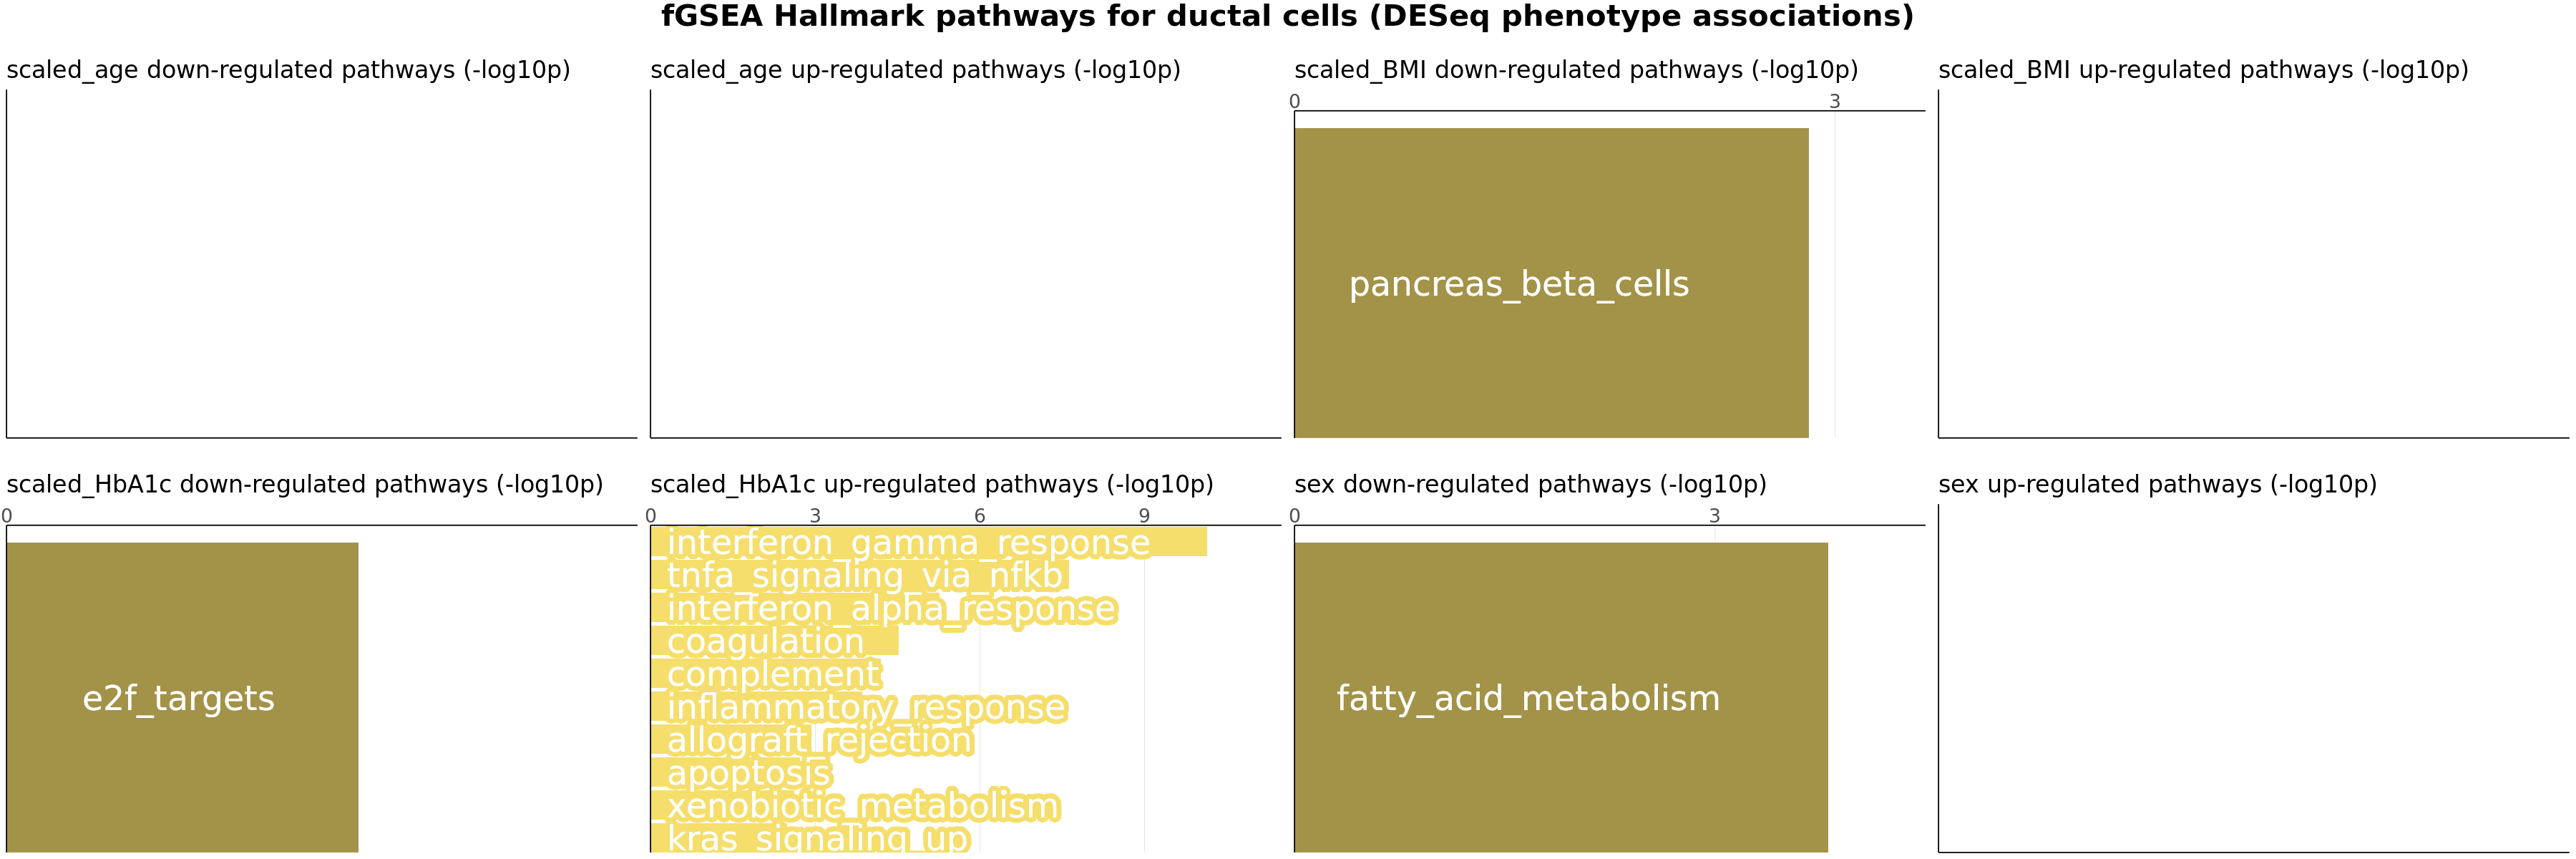

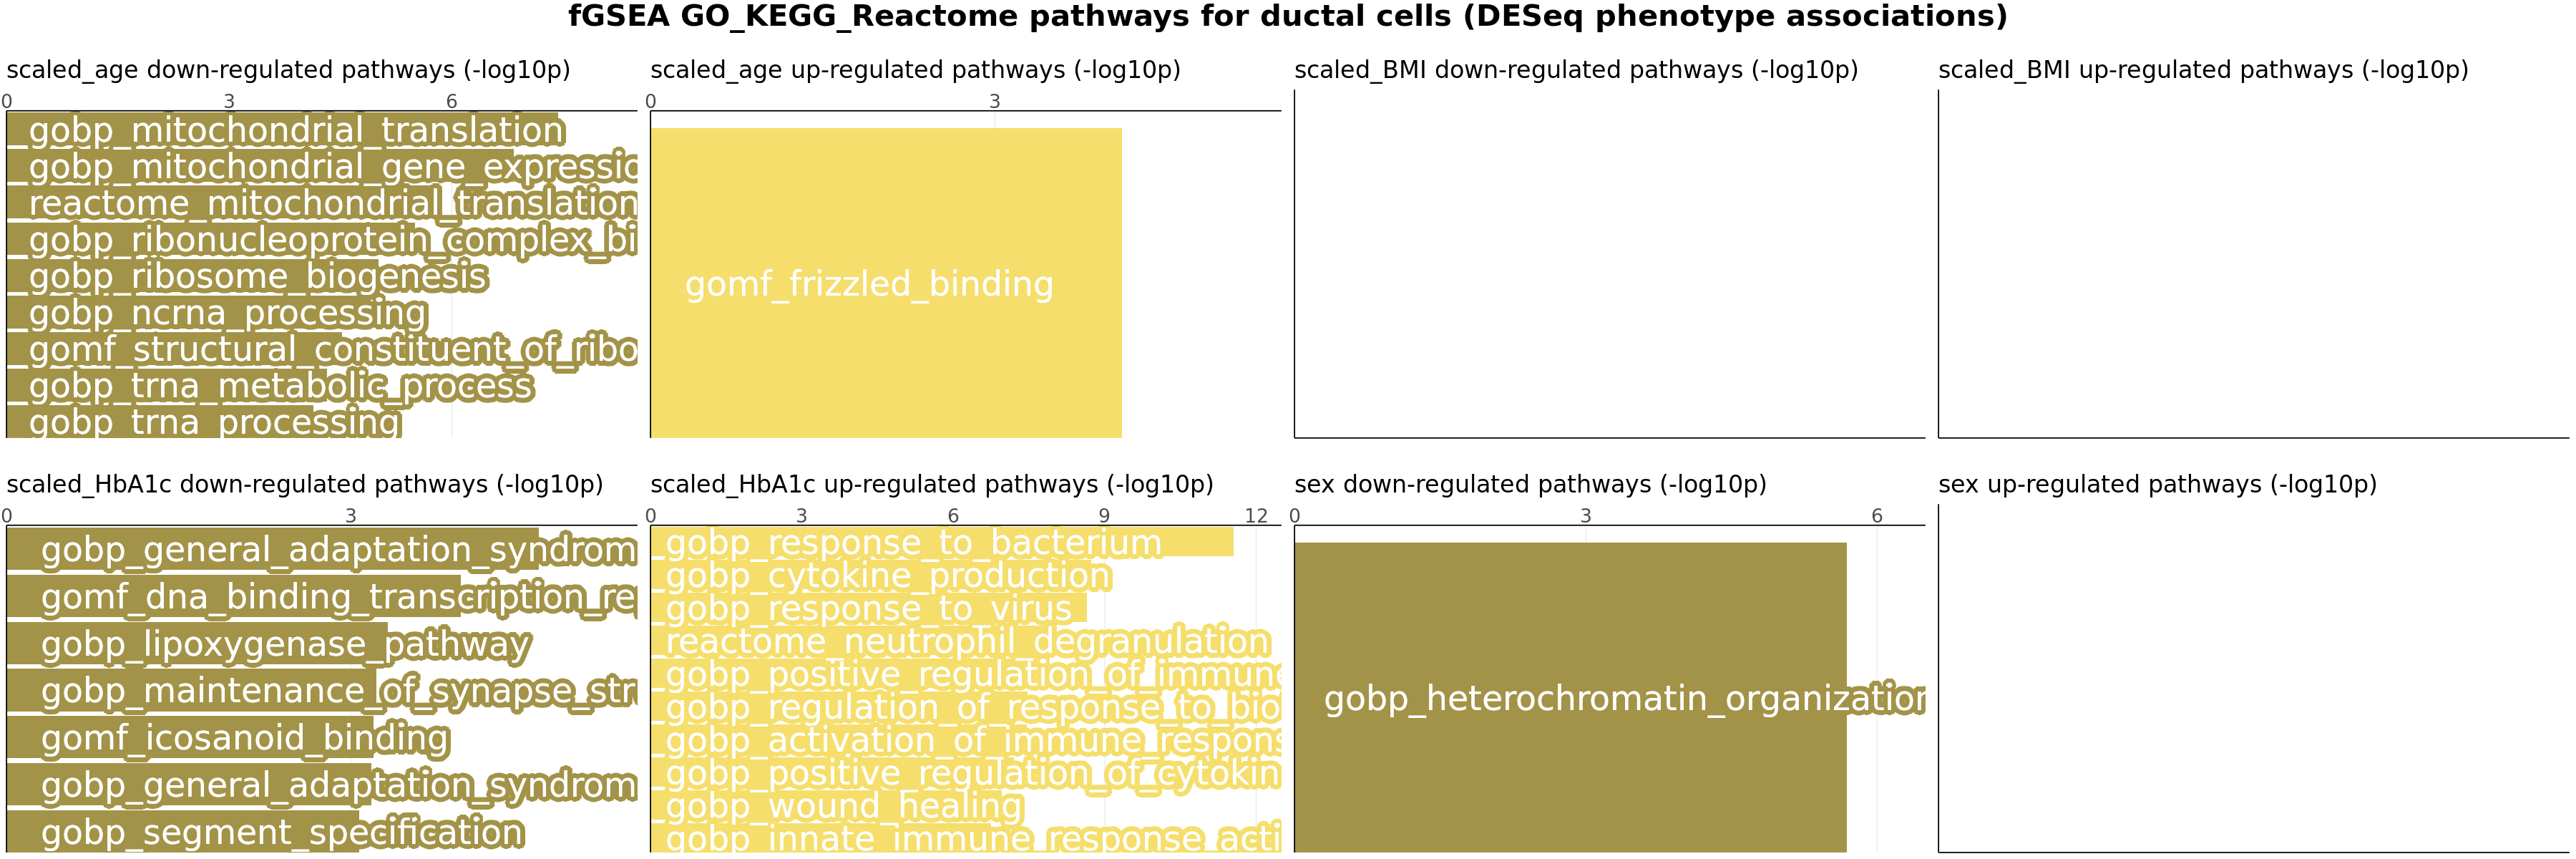

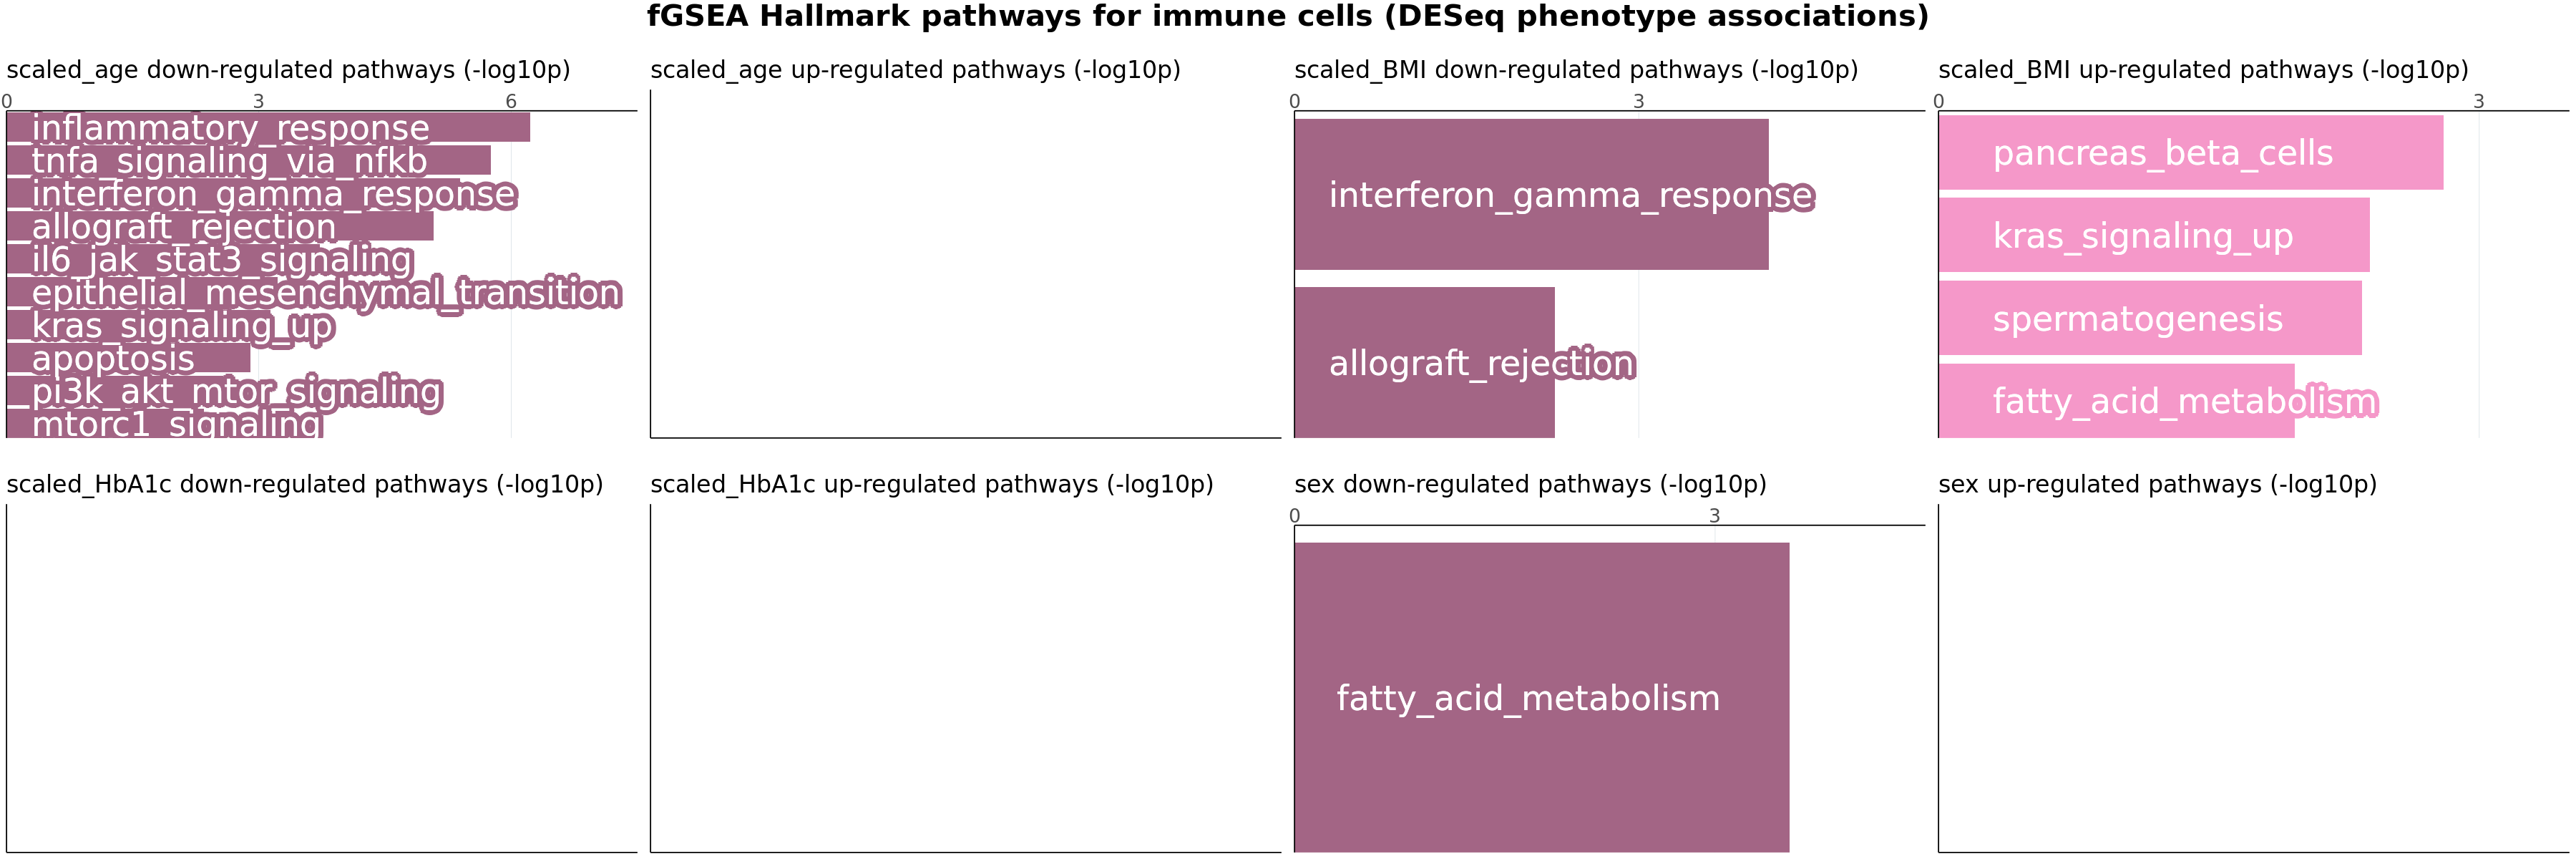

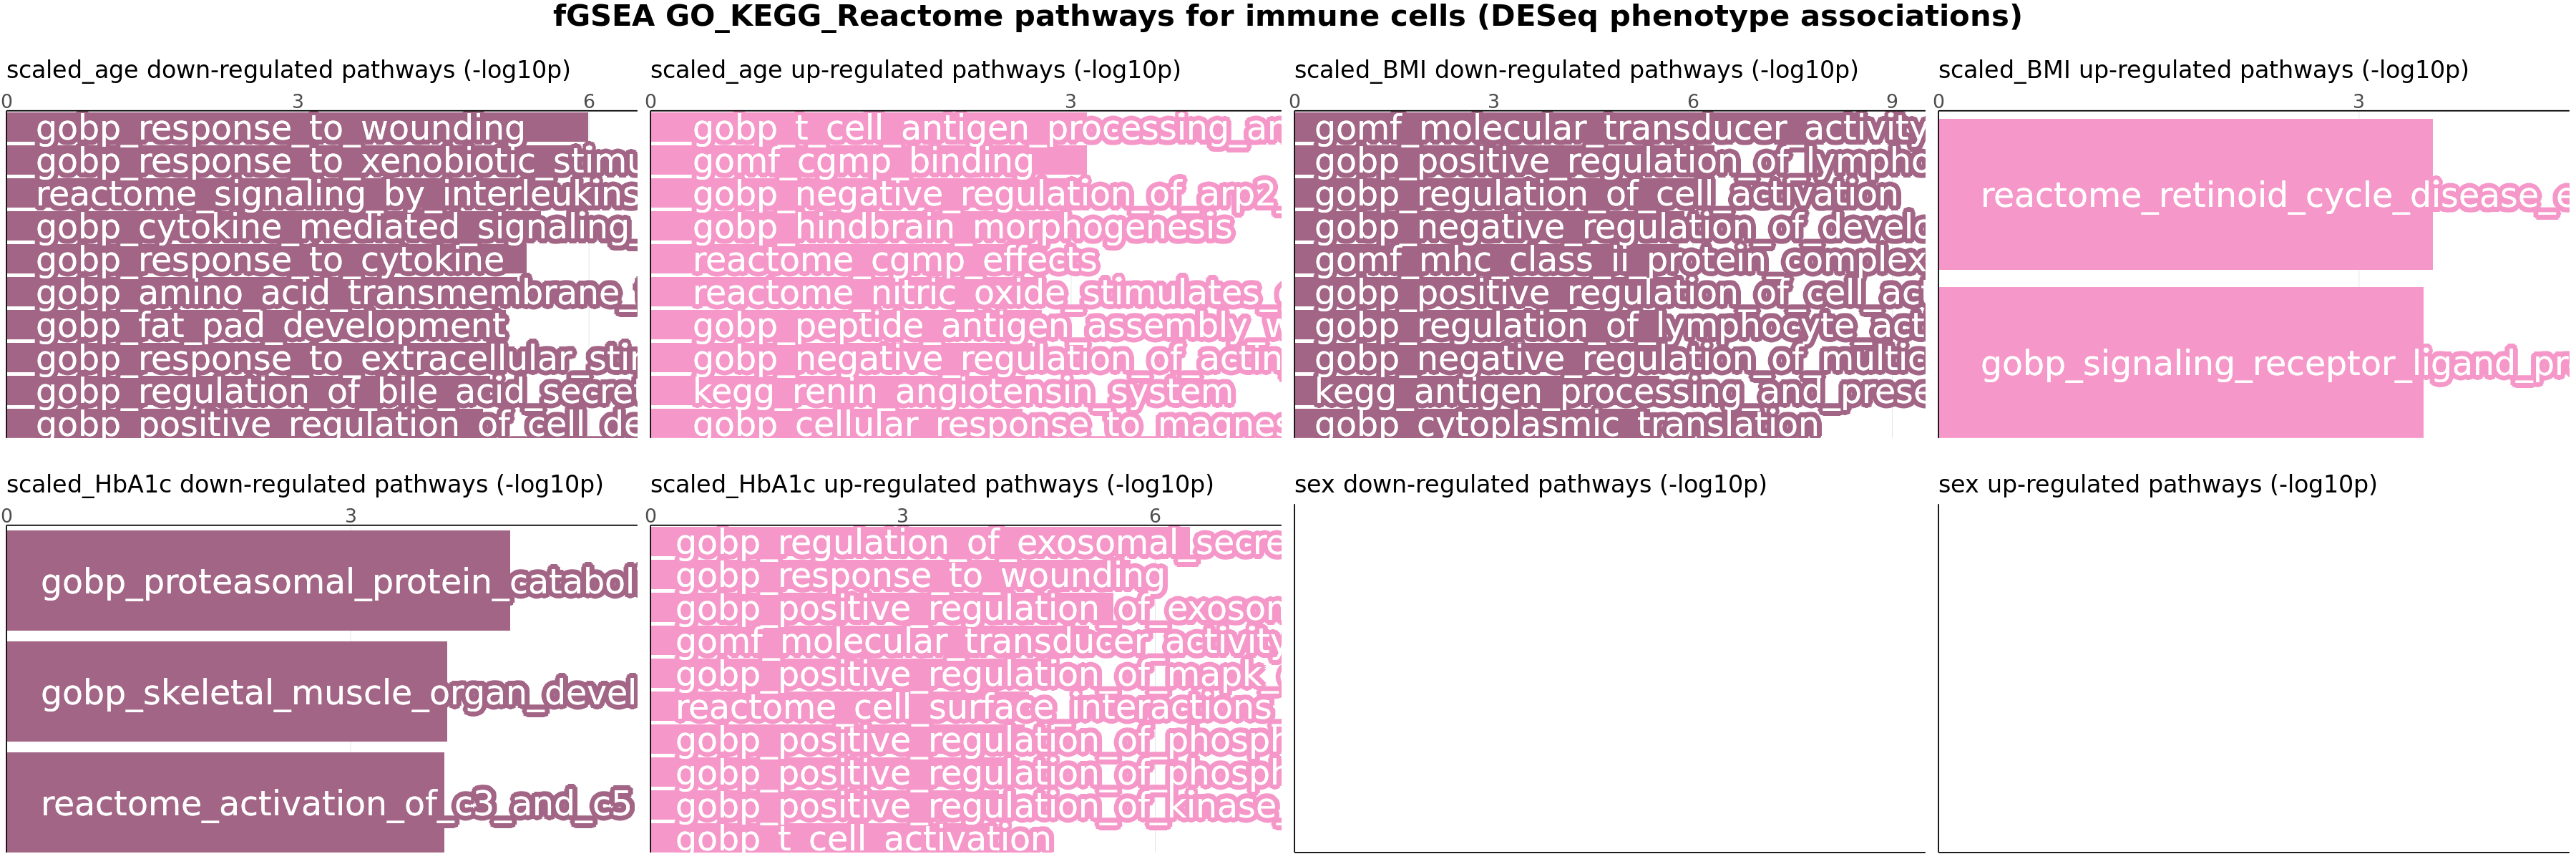

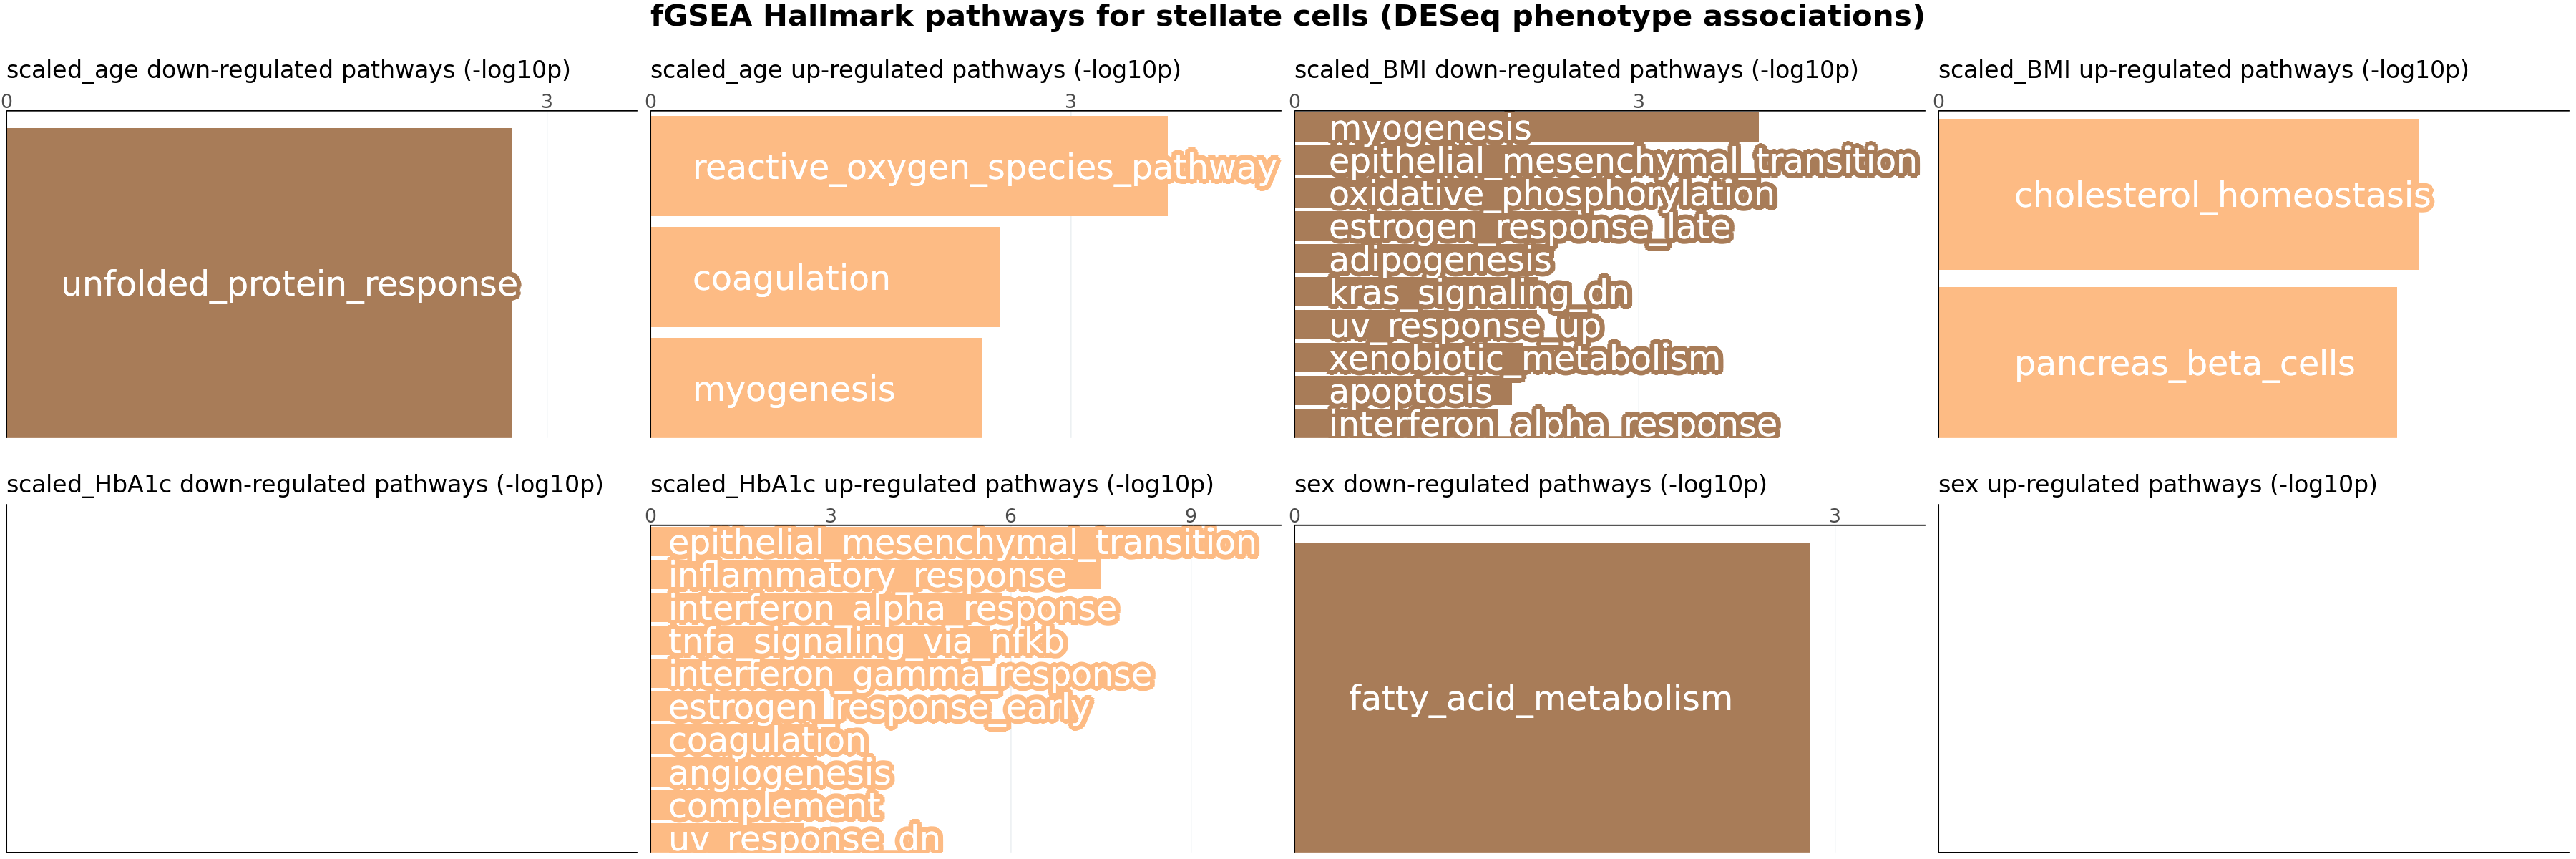

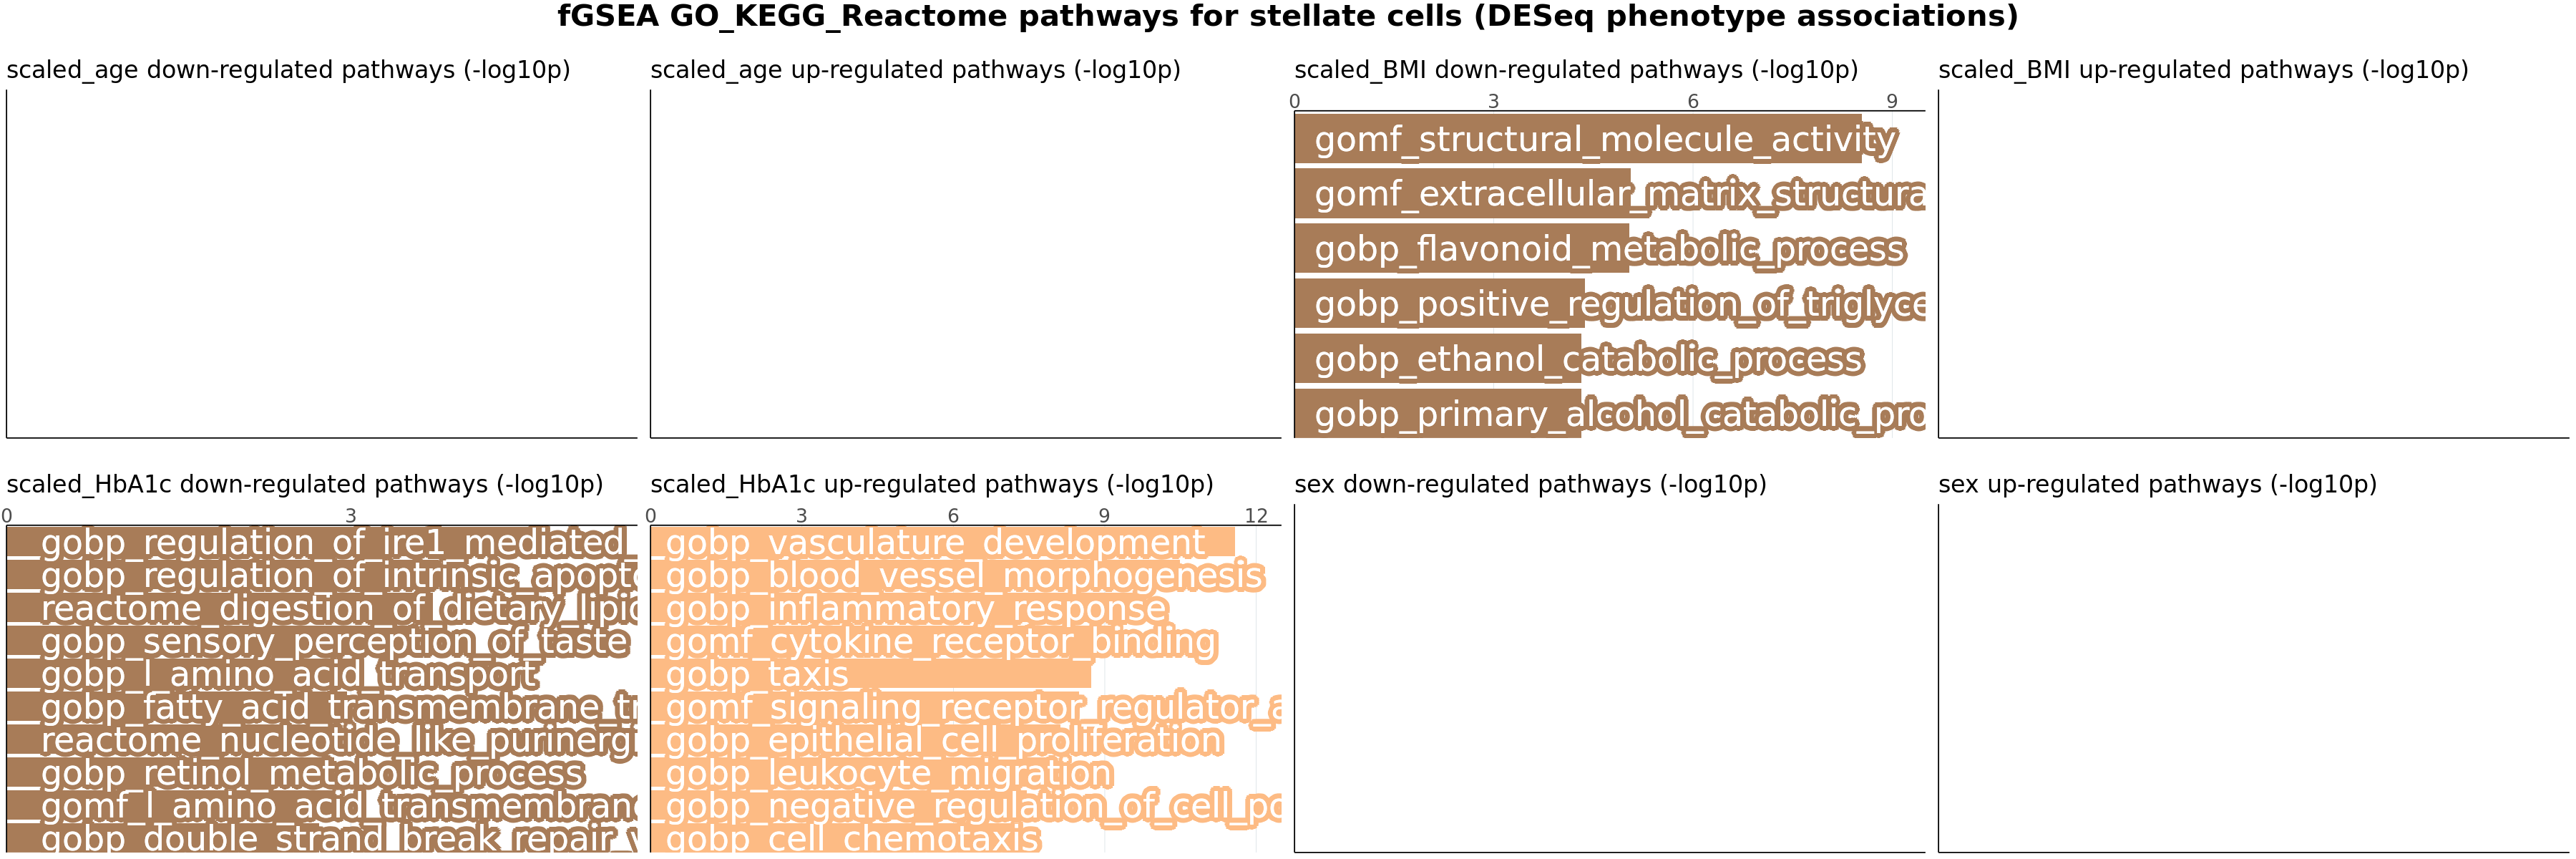

In [32]:
for (celltype in test_celltypes){
    make_ct_pathway_plots(celltype, traits, fgsea_outdir, 'Hallmark', 0.1, colors)
    make_ct_pathway_plots(celltype, traits, fgsea_outdir, 'GO_KEGG_Reactome', 0.1, colors)
}